# **The Battle of Neighborhoods: Chicago v. New York City**

We will be utilizing venue data from Foursquare, demographic data, and public crime data from Chicago and New York City (NYC) to predict the occurence of property crimes at venue locations depending on venue category, venue location, and neighborhood demographics.

First, we'll gather our data and prepare it for analysis through wrangling and data cleaning, then we'll perform clustering before preparing the prediction ML algorithm. 

Let's import the necessary libraries.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import json 
import geocoder
from pandas import json_normalize
from sklearn.cluster import KMeans
import folium 
from geopy.distance import geodesic
import operator
import itertools
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

print('Libraries imported.')

Libraries imported.


# Gathering Data


## Neighborhood Data

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### **Chicago**

Next, we use `BeautifulSoup4` to scrape the wiki pages of Chicago to get a list of its community areas from the following link:

Chicago: https://en.wikipedia.org/wiki/Community_areas_in_Chicago#List_of_community_areas


In [3]:
# For Chicago
url_c = requests.get('https://en.wikipedia.org/wiki/Community_areas_in_Chicago#List_of_community_areas')
soup_c = BeautifulSoup(url_c.content,'html.parser')

interest_c = soup_c.find('table')
rows_c = interest_c.find('tbody').find_all('tr')
rows_c_array=[] #to convert into ndarray
for x in rows_c:
    x_lst = [] #this would be a single row
    for y in x.find_all('th'):
        x_lst.append(y.get_text())
    x_lst = list(map(lambda s: s.strip(), x_lst)) #stripping the rows of whitespace characters that were carried over from the HTML script
    rows_c_array.append(x_lst)

Let's make it into a dataframe

In [4]:
df_c = pd.DataFrame(rows_c_array)
df_c.drop(columns=[1,2,3,4,5,6], index=[0], inplace=True)
df_c.rename(columns={0:'Community Area'}, inplace=True)
df_c.reset_index(inplace=True)
df_c.drop(columns=['index'],index=[77], inplace=True)
df_c

,Community Area
0,Rogers Park
1,West Ridge
2,Uptown
3,Lincoln Square
4,North Center
5,Lake View
6,Lincoln Park
7,Near North Side
8,Edison Park
9,Norwood Park


In [5]:
df_c.loc[31,'Community Area'] = 'Loop'

Let's add columns for latitude and longitude

In [6]:
df_c.loc[:, 'Latitude'] = np.nan
df_c.loc[:, 'Longitude'] = np.nan

And use the `geocoder` library to get each community area's coordinates

In [7]:
df_c.rename(columns={'Community Area':'Neighborhood'}, inplace=True)   #for ease of use later on

for x in df_c['Neighborhood']:
    nindex = df_c.set_index('Neighborhood').index.get_loc(x)
    coords = None
    while(coords is None):
        g = geocoder.bing('{}, Chicago'.format(x), key='As1R7w1ShKBfPP0G1D40E18xHxVX_bgYkc6Asvvf2YpzNWxCRn5VtixACZwMnFTp')
        coords = g.latlng
    df_c.at[nindex, 'Latitude'] = coords[0]
    df_c.at[nindex, 'Longitude'] = coords[1]

In [8]:
df_c.head()

,Neighborhood,Latitude,Longitude
0,Rogers Park,42.010311,-87.670135
1,West Ridge,42.003090,-87.694931
2,Uptown,41.967789,-87.652428
3,Lincoln Square,41.974934,-87.687935
4,North Center,41.946815,-87.683388


And let's map our neighborhoods using `folium`

In [9]:
h1 = geocoder.bing('Chicago, Illinois', key='As1R7w1ShKBfPP0G1D40E18xHxVX_bgYkc6Asvvf2YpzNWxCRn5VtixACZwMnFTp')
location1 = h1.latlng
map_chicago = folium.Map(location=[location1[0],location1[1]], zoom_start=10)

for lat, lng, neigh in zip(df_c['Latitude'], df_c['Longitude'], df_c['Neighborhood']):
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)
    
map_chicago

#### **New York City**

For NYC, we can use a pre-existing geoJSON **[file](https://maps.princeton.edu/download/file/sde-columbia-census_2000_032807211977000-geojson.json)** to get NYC's sub-borough area shapefile. We're using its sub-boroughs instead of its neighborhoods for the later part of the analysis where data could only be compiled on a sub-borough level.

In [10]:
# Uncomment to download
#import wget
#wget.download('https://maps.princeton.edu/download/file/sde-columbia-census_2000_032807211977000-geojson.json','ny_sba.json')

    
#print('Data downloaded!')

In [11]:
with open('ny_sba.json') as json_data:
    ny_sba_data = json.load(json_data)

In [12]:
ny_sub = ny_sba_data['features']

Since the sub-boroughs are mapped as multi-polygons in the json file, we are going to find the centre of each borough by using a simple centroid calculation function

In [13]:
def centroid(x_lst,y_lst):
    _len = len(x_lst)
    _x = sum(x_lst)/_len
    _y = sum(y_lst)/_len
    return(_x,_y)

In [14]:
sba = {}

for feature in ny_sub:
    x = []
    y = []
    for k in feature['geometry']['coordinates']:
        for i in k[0]:
            x.append(i[0])
            y.append(i[1])
    centre = centroid(x,y)
    key_s = feature['properties']['name']
    sba.update({key_s:centre})
    

    

In [15]:
df_ny = pd.DataFrame(sba).T
df_ny.reset_index(inplace=True)
df_ny.rename(columns={'index':'Neighborhood',0:'Longitude',1:'Latitude'}, inplace=True)
df_ny_lat = df_ny['Latitude']
df_ny.drop(columns='Latitude', inplace=True)
df_ny.insert(1,'Latitude',df_ny_lat)
df_ny.head()

,Neighborhood,Latitude,Longitude
0,North Shore,40.625868,-74.121420
1,East Harlem,40.797080,-73.937853
2,Mid-Island,40.591955,-74.139206
3,South Shore,40.546617,-74.167196
4,Washington Heights / Inwood,40.839632,-73.942751


In [16]:
df_ny.drop(index=[3], inplace=True) # Dropping South Shore because it doesn't exist in demographic dataset

Now finally, let's map the sub-boroughs.

In [17]:
h2 = geocoder.bing('New York City, New York', key='As1R7w1ShKBfPP0G1D40E18xHxVX_bgYkc6Asvvf2YpzNWxCRn5VtixACZwMnFTp')
location2 = h2.latlng
map_ny = folium.Map(location=[location2[0],location2[1]], zoom_start=10)

for lat, lng, neigh in zip(df_ny['Latitude'], df_ny['Longitude'], df_ny['Neighborhood']):
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)
    
map_ny

## Venue Data

We will now begin to use the Foursquare API to get venue details for each neighborhood within a radius of 1km for Chicago and 1.5km for NYC. To make the API call, it requires a unique `CLIENT_ID` and `CLIENT_SECRET` that is generated when creating a Foursquare [account](https://foursquare.com/developers/signup) 

In [18]:
CLIENT_ID = 'DL5GYQMRSFCW3SIQZXTRSII0AYDVFS45U2H4WJJFFPPNZHTJ'
CLIENT_SECRET = 'TG1TYEHYIDNJB2NL5TBG2RVKTOOL1MXA0NZJIPM4XGIHI01N'
VERSION = '20180605'

print('''Your credentials: 
CLIENT_ID: %s
ClIENT_SECRET: %s''' % (CLIENT_ID, CLIENT_SECRET))

Your credentials: 
CLIENT_ID: DL5GYQMRSFCW3SIQZXTRSII0AYDVFS45U2H4WJJFFPPNZHTJ
ClIENT_SECRET: TG1TYEHYIDNJB2NL5TBG2RVKTOOL1MXA0NZJIPM4XGIHI01N


And we'll create a function to get venues for every city

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        code = 500  # To try again in case of internal server error
        request = {}
        count = 0
        while code == 500 and count < 11:
            request = requests.get(url).json()
            code = request['meta']['code']
            count += 1
        if count == 10 and code == 500:  # to prevent excessive GET requests in case of internal server error or bad requests
            print('Server timeout, tried 10 requests.')
            break
        results = request["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'id']
    
    return(nearby_venues)




First, we'll compile Chicago data

In [20]:
c_venues = getNearbyVenues(names=df_c['Neighborhood'],
                           latitudes = df_c['Latitude'],
                           longitudes = df_c['Longitude'],
                           radius=1000,
                           limit=200)

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt Park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
Loop
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly
Washington Heights
Mount Greenwood
Morgan Park
O'Hare
Edgewater


In [21]:
c_venues.shape

(4154, 8)

In [22]:
c_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,id
0,Rogers Park,42.010311,-87.670135,Morse Fresh Market,42.008087,-87.667041,Grocery Store,4ad3bfc1f964a52017e620e3
1,Rogers Park,42.010311,-87.670135,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant,4b6ed827f964a5200bcd2ce3
2,Rogers Park,42.010311,-87.670135,Lifeline Theatre,42.007372,-87.666284,Theater,4afe1044f964a520962d22e3
3,Rogers Park,42.010311,-87.670135,Rogers Park Social,42.007360,-87.666265,Bar,536300da498ee44e63dcbc1d
4,Rogers Park,42.010311,-87.670135,Glenwood Sunday Market,42.008525,-87.666251,Farmers Market,516ae9c5498e8ffe6820c740


Now, NYC

In [23]:
ny_venues = getNearbyVenues(names=df_ny['Neighborhood'], 
                            latitudes=df_ny['Latitude'],
                            longitudes=df_ny['Longitude'],
                            radius=1500,
                            limit=200)

North Shore
East Harlem
Mid-Island
Washington Heights / Inwood
Astoria
Jackson Heights
Sunnyside / Woodside
Lower East Side / Chinatown
Elmhurst / Corona
Middle Village / Ridgewood
Forest Hills / Rego Park
Flushing / Whitestone
Chelsea / Clinton / Midtown
Hillcrest / Fresh Meadows
Kew Gardens / Woodhaven
Howard Beach / S. Ozone Park
Stuyvesant Town / Turtle Bay
Bayside / Little Neck
Upper East Side
Jamaica
Morningside Heights / Hamilton Heights
Bellerose / Rosedale
Rockaways
Greenwich Village / Financial District
Upper West Side
Central Harlem
Mott Haven / Hunts Point
Morrisania / East Tremont
Highbridge / S. Concourse
University Heights / Fordham
Kingsbridge Heights / Mosholu
Riverdale / Kingsbridge
Soundview / Parkchester
Throgs Neck / Co-op City
Pelham Parkway
Williamsbridge / Baychester
Bay Ridge
Williamsburg / Greenpoint
Bushwick
Bedford Stuyvesant
Brooklyn Heights / Fort Greene
Park Slope / Carroll Gardens
North Crown Heights / Prospect Heights
Brownsville / Ocean Hill
East New Y

In [24]:
ny_venues.shape

(4916, 8)

In [25]:
ny_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,id
0,North Shore,40.625868,-74.12142,Staten Island Zoo,40.625083,-74.115752,Zoo,49f21ff8f964a520eb691fe3
1,North Shore,40.625868,-74.12142,Egger's Ice Cream Parlor,40.626235,-74.129716,Ice Cream Shop,4bafe629f964a520f3293ce3
2,North Shore,40.625868,-74.12142,Call It A Wrap,40.626147,-74.129899,New American Restaurant,4b6215f0f964a5209b342ae3
3,North Shore,40.625868,-74.12142,CakeChef's Cookie Jar,40.626323,-74.130702,Dessert Shop,4bd30b57046076b024017571
4,North Shore,40.625868,-74.12142,DSPTCH,40.627542,-74.118110,Luggage Store,58251526042fc73e59352817


Check for duplicates from neighborhood radius overlap

In [26]:
print(c_venues.shape)
c_venues.drop_duplicates(subset=['Venue Latitude','Venue Longitude'], keep='first', inplace=True)
print(c_venues.shape)

print(ny_venues.shape)
ny_venues.drop_duplicates(subset=['Venue Latitude','Venue Longitude'], keep='first', inplace=True)
print(ny_venues.shape)


(4154, 8)
(3971, 8)
(4916, 8)
(4592, 8)


Let's get a count of venues in every neighborhood

In [27]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [28]:
# Chicago
c_venue_count = c_venues[['Neighborhood','id']].groupby('Neighborhood').count()
c_venue_count.rename(columns={'id':'count'}, inplace=True)
c_venue_count.sort_values('count', axis=0, ascending=False, inplace=True)
c_venue_count.head()

,count
Neighborhood,
Lincoln Park,100
Edgewater,100
Irving Park,100
Lake View,100
Lincoln Square,100


Text(0, 0.5, 'Frequency')

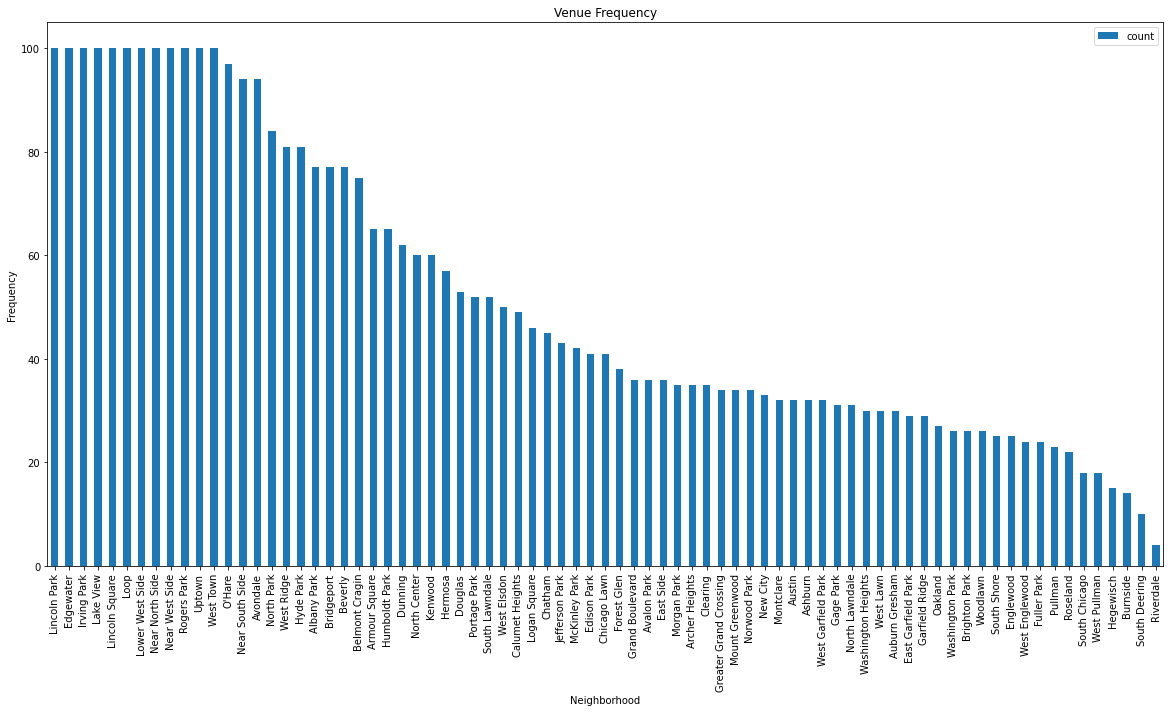

In [29]:
# Chicago
ax1 = c_venue_count.plot(kind='bar',figsize=(20,10))
ax1.set_title('Venue Frequency')
ax1.set_xlabel('Neighborhood')
ax1.set_ylabel('Frequency')

In [30]:
# New York
ny_venue_count = ny_venues[['Neighborhood','id']].groupby('Neighborhood').count()
ny_venue_count.rename(columns={'id':'count'}, inplace=True)
ny_venue_count.sort_values('count', axis=0, ascending=False, inplace=True)
ny_venue_count.head()


,count
Neighborhood,
Astoria,100
Flushing / Whitestone,100
Washington Heights / Inwood,100
Upper West Side,100
Upper East Side,100


Text(0, 0.5, 'Frequency')

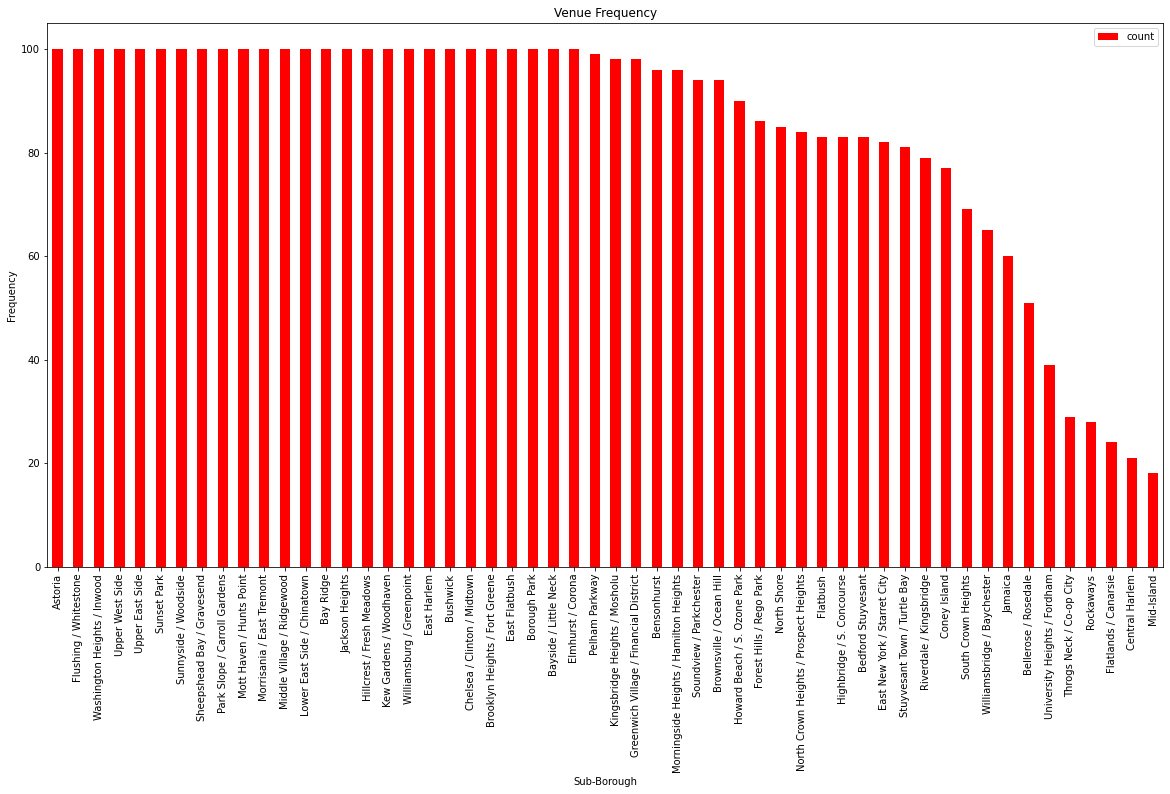

In [31]:
# New York
ax2 = ny_venue_count.plot(kind='bar',figsize=(20,10), color='red')
ax2.set_title('Venue Frequency')
ax2.set_xlabel('Sub-Borough')
ax2.set_ylabel('Frequency')

## Crime Data

#### **Chicago**

First we import the datasets which were taken from:
* Chicago: https://data.cityofchicago.org/Public-Safety/Crimes-Map/dfnk-7re6 
* New York: https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u/data 

In [32]:
#Uncomment to download
#import wget
#wget.download('https://data.cityofchicago.org/api/views/dfnk-7re6/rows.csv?accessType=DOWNLOAD','chicago_crime.csv')

In [33]:
df_crime_c = pd.read_csv('chicago_crime.csv')

In [34]:
df_crime_c.shape

(234545, 17)

In [35]:
df_crime_c.head()

,CASE#,DATE OF OCCURRENCE,BLOCK,IUCR,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,LOCATION DESCRIPTION,ARREST,DOMESTIC,BEAT,WARD,FBI CD,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,JD141525,02/05/2020 02:54:00 PM,030XX N HALSTED ST,0860,THEFT,RETAIL THEFT,DRUG STORE,N,N,1933,44.0,06,NaN,NaN,NaN,NaN,NaN
1,JD205528,04/09/2020 02:00:00 PM,029XX S ARCHER AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,N,N,913,11.0,14,1168260.0,1885596.0,41.841609,-87.658034,"(41.841609341, -87.65803375)"
2,JD177980,03/08/2020 02:15:00 AM,064XX S DR MARTIN LUTHER KING JR DR,1330,CRIMINAL TRESPASS,TO LAND,APARTMENT,Y,N,312,20.0,26,1180028.0,1862391.0,41.777671,-87.615561,"(41.777670858, -87.61556066)"
3,JC497784,11/03/2019 11:40:00 AM,032XX N CLARK ST,0860,THEFT,RETAIL THEFT,DEPARTMENT STORE,N,N,1924,44.0,06,NaN,NaN,NaN,NaN,NaN
4,JD195928,03/21/2020 10:05:00 PM,019XX E 73RD PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,N,N,333,7.0,11,NaN,NaN,NaN,NaN,NaN


Let's clean it up a bit

In [36]:
df_crime_c.drop(columns=[' IUCR','BEAT','WARD','FBI CD','BLOCK',' LOCATION DESCRIPTION','ARREST','DOMESTIC',
                         'X COORDINATE','Y COORDINATE'], inplace=True)

In [37]:
df_crime_c.dropna(axis=0, subset=['LOCATION'], inplace=True)

In [38]:
df_crime_c.shape

(233172, 7)

In [39]:
df_crime_c.drop(columns=['LOCATION'], inplace=True)

In [40]:
df_crime_c.columns

Index(['CASE#', 'DATE  OF OCCURRENCE', ' PRIMARY DESCRIPTION',
       ' SECONDARY DESCRIPTION', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [41]:
df_crime_c.rename(columns={'CASE#':'id','DATE  OF OCCURRENCE':'date',' PRIMARY DESCRIPTION':'primary',
                           ' SECONDARY DESCRIPTION':'secondary','LATITUDE':'Latitude','LONGITUDE':'Longitude'
                          }, inplace=True)

In [42]:
df_crime_c.reset_index(inplace=True)
df_crime_c.drop(columns=['index'], inplace=True)

In [43]:
df_crime_c.head()

,id,date,primary,secondary,Latitude,Longitude
0,JD205528,04/09/2020 02:00:00 PM,CRIMINAL DAMAGE,TO VEHICLE,41.841609,-87.658034
1,JD177980,03/08/2020 02:15:00 AM,CRIMINAL TRESPASS,TO LAND,41.777671,-87.615561
2,JD218694,04/27/2020 10:49:00 PM,CRIMINAL DAMAGE,CRIMINAL DEFACEMENT,41.969365,-87.728061
3,JD218865,04/27/2020 06:20:00 PM,CRIMINAL DAMAGE,TO VEHICLE,41.803121,-87.609460
4,JD218362,04/27/2020 02:04:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,41.733015,-87.552709


Text(0, 0.5, 'Crime Frequency')

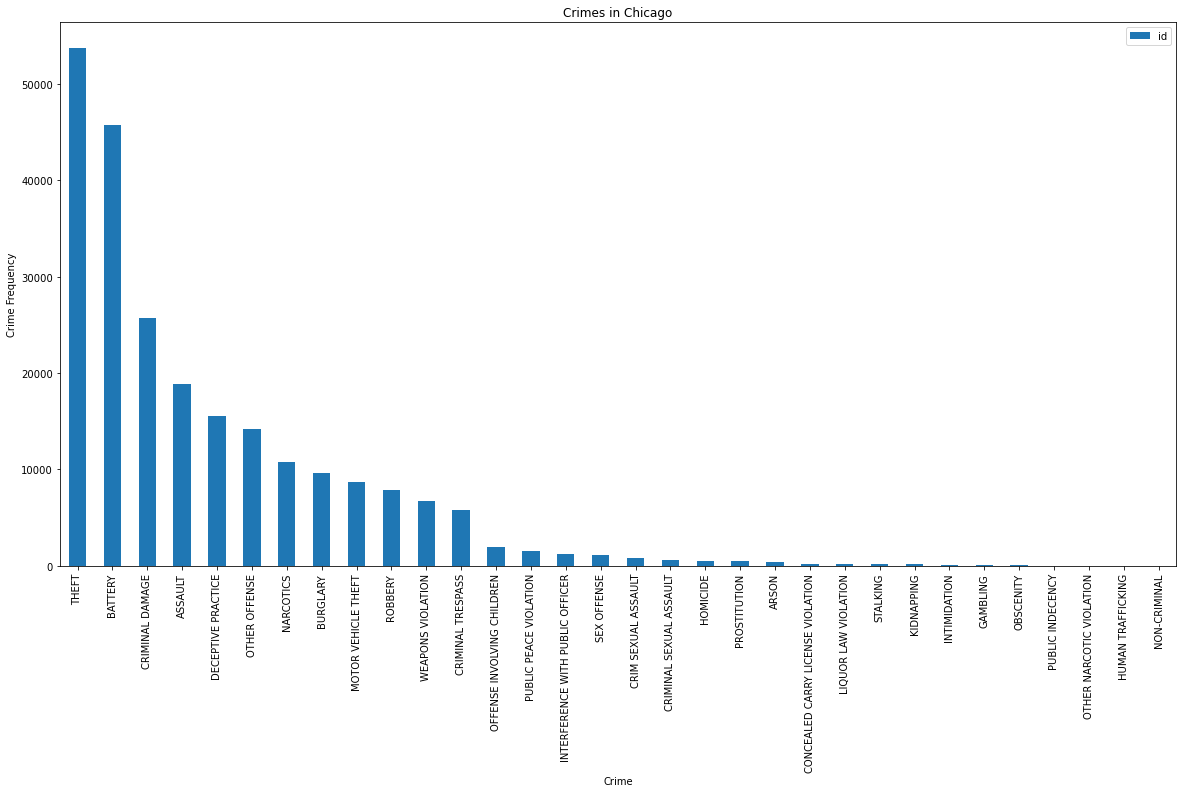

In [44]:
df_crime_c_count = df_crime_c[['primary','id']].groupby('primary').count()
df_crime_c_count.sort_values('id',axis=0, ascending=False, inplace=True)
ax3 = df_crime_c_count.plot(kind='bar', figsize=(20,10))
ax3.set_title('Crimes in Chicago')
ax3.set_xlabel('Crime')
ax3.set_ylabel('Crime Frequency')

Since our analysis only deals with venues, we should restrict the dataset to property crimes only, and particularly **THEFT, CRIMINAL DAMAGE, BURGLARY, ROBBERY, CRIMINAL TRESPASS, ARSON,** and **INTIMIDATION**

In [45]:
df_crime_c = df_crime_c.loc[df_crime_c['primary'].isin(['THEFT','CRIMINAL DAMAGE','BURGLARY','ROBBERY','CRIMINAL TRESPASS','ARSON','INTMIDATION'])]
print(df_crime_c.shape)
df_crime_c.head()

(103126, 6)


,id,date,primary,secondary,Latitude,Longitude
0,JD205528,04/09/2020 02:00:00 PM,CRIMINAL DAMAGE,TO VEHICLE,41.841609,-87.658034
1,JD177980,03/08/2020 02:15:00 AM,CRIMINAL TRESPASS,TO LAND,41.777671,-87.615561
2,JD218694,04/27/2020 10:49:00 PM,CRIMINAL DAMAGE,CRIMINAL DEFACEMENT,41.969365,-87.728061
3,JD218865,04/27/2020 06:20:00 PM,CRIMINAL DAMAGE,TO VEHICLE,41.803121,-87.609460
5,JD219384,04/27/2020 06:00:00 PM,THEFT,$500 AND UNDER,41.708243,-87.639226


In [46]:
df_crime_c.reset_index(inplace=True)
df_crime_c.drop(columns=['index'], inplace=True)
df_crime_c.head()

,id,date,primary,secondary,Latitude,Longitude
0,JD205528,04/09/2020 02:00:00 PM,CRIMINAL DAMAGE,TO VEHICLE,41.841609,-87.658034
1,JD177980,03/08/2020 02:15:00 AM,CRIMINAL TRESPASS,TO LAND,41.777671,-87.615561
2,JD218694,04/27/2020 10:49:00 PM,CRIMINAL DAMAGE,CRIMINAL DEFACEMENT,41.969365,-87.728061
3,JD218865,04/27/2020 06:20:00 PM,CRIMINAL DAMAGE,TO VEHICLE,41.803121,-87.609460
4,JD219384,04/27/2020 06:00:00 PM,THEFT,$500 AND UNDER,41.708243,-87.639226


The database still consists of over 100,000 entries, we need to trim the dataset to save on computing time so, we shall take a random sample of ~1/5<sup>th</sup> of the original size (about 20,000 entries)

In [47]:
import random

index_del_range = list(range(0,df_crime_c.shape[0]))
index_del = random.sample(index_del_range, (int(df_crime_c.shape[0]/5)*4))
print('Operation Completed')

Operation Completed


In [48]:
df_crime_c.drop(index=index_del, inplace=True)

In [49]:
df_crime_c_count = df_crime_c[['primary','id']].groupby('primary').count()

Text(0, 0.5, 'Frequency')

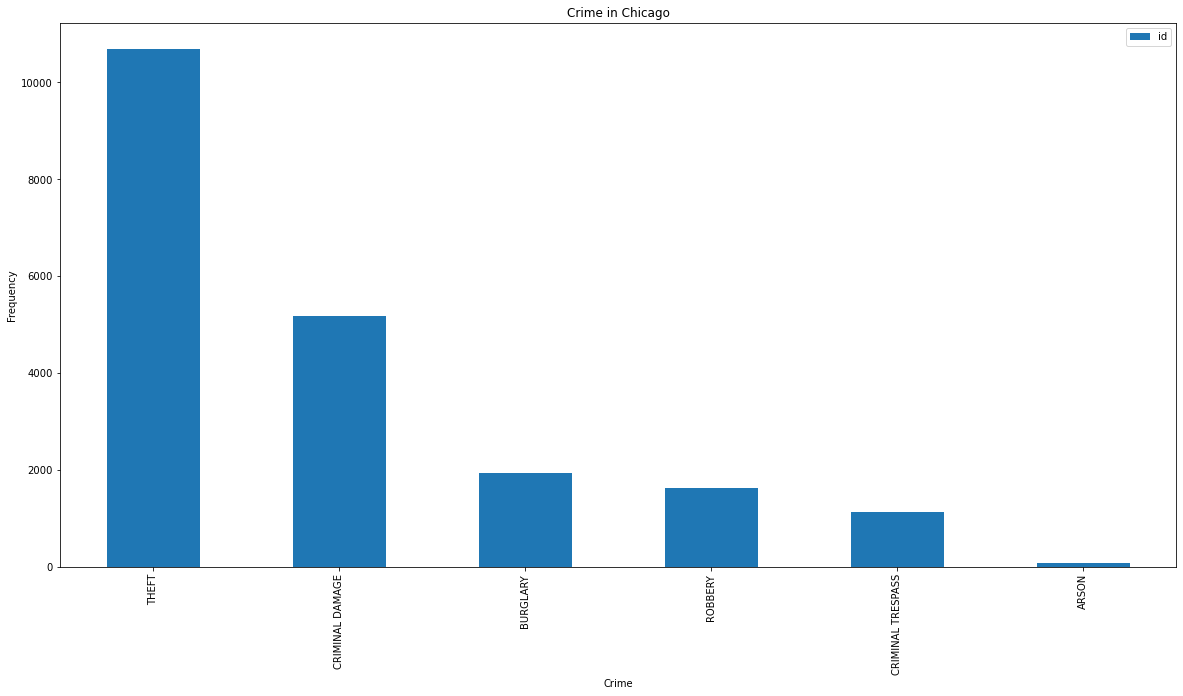

In [50]:
df_crime_c_count.sort_values('id',axis=0,ascending=False, inplace=True)
ax3 = df_crime_c_count.plot(kind='bar', figsize=(20,10))
ax3.set_title('Crime in Chicago')
ax3.set_xlabel('Crime')
ax3.set_ylabel('Frequency')

#### **New York**

In [51]:
#Uncomment to download
#import wget
#wget.download('https://data.cityofnewyork.us/api/views/8h9b-rp9u/rows.csv?accessType=DOWNLOAD','newyork_crime.csv')

In [52]:
df_crime_n = pd.read_csv('newyork_crime.csv')

In [53]:
print(df_crime_n.shape)
df_crime_n.head()

(214069, 18)


,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,191778794,01/02/2019,339.0,"LARCENY,PETIT FROM OPEN AREAS,",341.0,PETIT LARCENY,PL 1552500,M,M,26,0,25-44,M,BLACK,993898,232335,40.804385,-73.965152
1,191778772,01/02/2019,759.0,"PUBLIC ADMINISTATION,UNCLASS M",359.0,OFFENSES AGAINST PUBLIC ADMINI,PL 2052001,M,B,41,72,18-24,F,BLACK,1017934,232221,40.804013,-73.878332
2,191735834,01/02/2019,114.0,OBSTR BREATH/CIRCUL,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1211100,M,M,34,0,25-44,M,WHITE HISPANIC,1004441,252707,40.860282,-73.927008
3,191773009,01/02/2019,339.0,"LARCENY,PETIT FROM OPEN AREAS,",341.0,PETIT LARCENY,PL 1552500,M,K,75,0,25-44,F,BLACK,1020754,176733,40.651701,-73.868447
4,191773004,01/02/2019,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,B,52,0,25-44,M,WHITE HISPANIC,1015727,258224,40.875392,-73.886182


Let's remove all the unnecessary columns for this analysis, we're only interested in the **OFNS_DESC** crime description columns as it is more general than the granular **PD_DESC** column, we also have to unfortunately drop any columns containing demographic information as the Chicago dataset doesn't include the same level of detail. 

In [54]:
df_crime_n.drop(columns=['PD_CD','PD_DESC','KY_CD','LAW_CODE','LAW_CAT_CD','ARREST_BORO','ARREST_PRECINCT','JURISDICTION_CODE','AGE_GROUP',
                         'PERP_SEX','PERP_RACE','X_COORD_CD','Y_COORD_CD'], inplace=True)

Let's also drop any columns without location information

In [55]:
print(df_crime_n.shape)
df_crime_n.dropna(axis=0,subset=['Latitude','Longitude'],inplace=True)
print(df_crime_n.shape)

(214069, 5)
(214069, 5)


Let's rename the columns to match the Chicago dataset

In [56]:
df_crime_n.head()

,ARREST_KEY,ARREST_DATE,OFNS_DESC,Latitude,Longitude
0,191778794,01/02/2019,PETIT LARCENY,40.804385,-73.965152
1,191778772,01/02/2019,OFFENSES AGAINST PUBLIC ADMINI,40.804013,-73.878332
2,191735834,01/02/2019,ASSAULT 3 & RELATED OFFENSES,40.860282,-73.927008
3,191773009,01/02/2019,PETIT LARCENY,40.651701,-73.868447
4,191773004,01/02/2019,VEHICLE AND TRAFFIC LAWS,40.875392,-73.886182


In [57]:
df_crime_n.rename(columns={'ARREST_KEY':'id','ARREST_DATE':'date','OFNS_DESC':'primary'}, inplace=True)
df_crime_n.head()

,id,date,primary,Latitude,Longitude
0,191778794,01/02/2019,PETIT LARCENY,40.804385,-73.965152
1,191778772,01/02/2019,OFFENSES AGAINST PUBLIC ADMINI,40.804013,-73.878332
2,191735834,01/02/2019,ASSAULT 3 & RELATED OFFENSES,40.860282,-73.927008
3,191773009,01/02/2019,PETIT LARCENY,40.651701,-73.868447
4,191773004,01/02/2019,VEHICLE AND TRAFFIC LAWS,40.875392,-73.886182


Text(0, 0.5, 'Frequency')

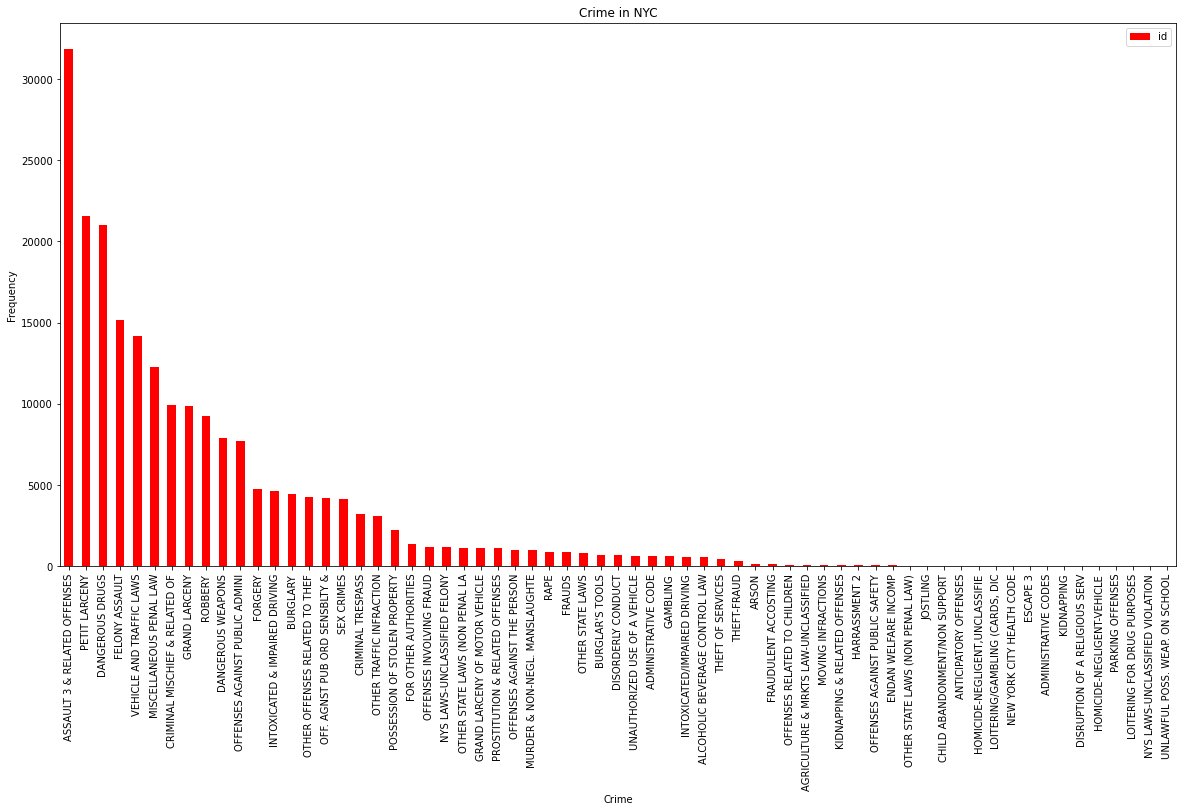

In [58]:
df_crime_n_count = df_crime_n[['primary','id']].groupby('primary').count()
df_crime_n_count.sort_values('id', axis=0, ascending=False, inplace=True)
ax4 = df_crime_n_count.plot(kind='bar', figsize=(20,10), color='red')
ax4.set_title('Crime in NYC')
ax4.set_xlabel('Crime')
ax4.set_ylabel('Frequency')

Again, we filter the crimes for property crimes only, here it includes **PETIT LARCENY, CRIMINAL MISCHIEF AND RELATED OF, GRAND LARCENY, ROBBERY, FORGERY, BURGLARY, OTHER OFFENSES RELATED TO THEF, CRIMINAL TRESPASS, POSSESSION OF STOLEN PROPERTY, OFFENSES INVOLVING FRAUD, FRAUDS, BURGLAR'S TOOLS, THEFT OF SERVICES, THEFT-FRAUD,** and **ARSON.**

In [59]:
df_crime_n = df_crime_n.loc[df_crime_n['primary'].isin(["PETIT LARCENY", "CRIMINAL MISCHIEF AND RELATED OF", "GRAND LARCENY", "ROBBERY", 
                                                        "FORGERY", "BURGLARY", "OTHER OFFENSES RELATED TO THEF", "CRIMINAL TRESPASS", 
                                                        "POSSESSION OF STOLEN PROPERTY", "OFFENSES INVOLVING FRAUD", "FRAUDS", 
                                                        "BURGLAR'S TOOLS", "THEFT OF SERVICES", "THEFT-FRAUD","ARSON"])]
print(df_crime_n.shape)
df_crime_n.head()

(63424, 5)


,id,date,primary,Latitude,Longitude
0,191778794,01/02/2019,PETIT LARCENY,40.804385,-73.965152
3,191773009,01/02/2019,PETIT LARCENY,40.651701,-73.868447
19,191785336,01/02/2019,FORGERY,40.641194,-73.919558
20,191753723,01/02/2019,PETIT LARCENY,40.742997,-73.984235
22,191756712,01/02/2019,PETIT LARCENY,40.732607,-73.997173


In [60]:
df_crime_n.reset_index(inplace=True)
df_crime_n.drop(columns=['index'], inplace=True)

Again, we want to limit the dataset to about 20,000 entries

In [61]:
index_del_range = list(range(0,df_crime_n.shape[0]))
index_del = random.sample(index_del_range, (int(df_crime_n.shape[0]/3)*2))
print('Operation Completed')

Operation Completed


In [62]:
df_crime_n.drop(index=index_del, inplace=True)

In [63]:
df_crime_n_count = df_crime_n[['primary','id']].groupby('primary').count()

Text(0, 0.5, 'Frequency')

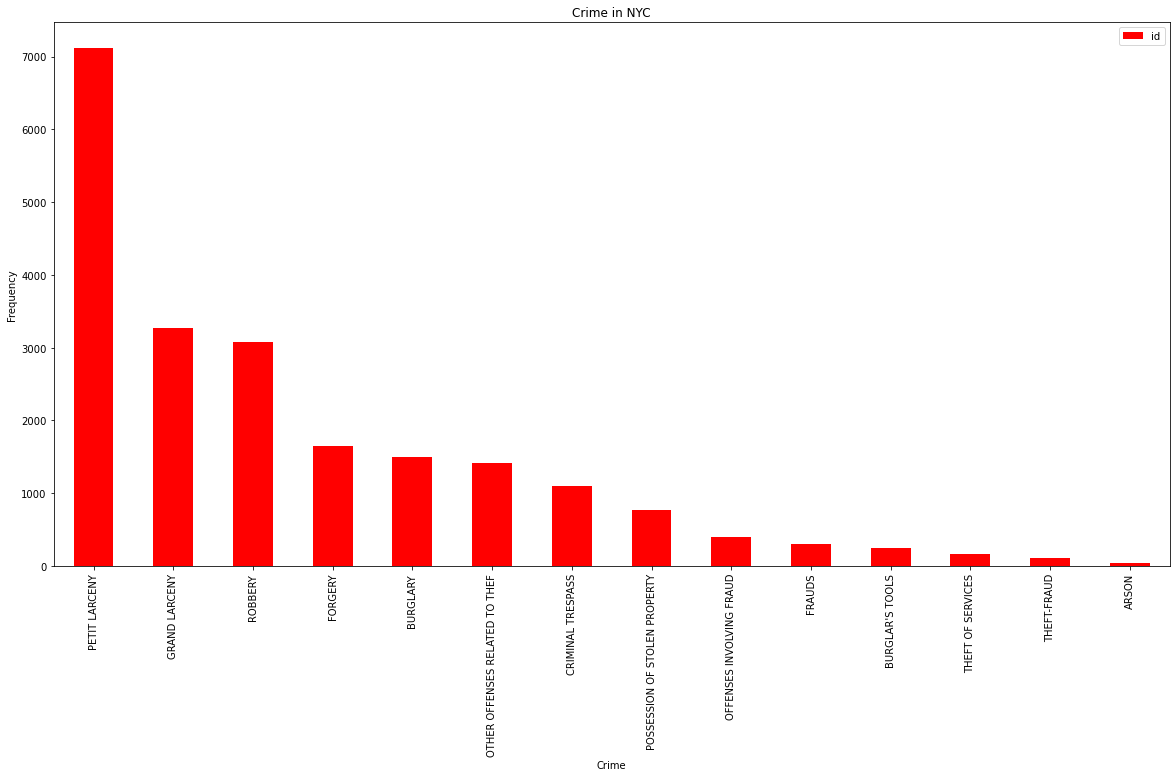

In [64]:
df_crime_n_count.sort_values('id',axis=0,ascending=False, inplace=True)
ax3 = df_crime_n_count.plot(kind='bar', figsize=(20,10), color='red')
ax3.set_title('Crime in NYC')
ax3.set_xlabel('Crime')
ax3.set_ylabel('Frequency')

In [65]:
df_crime_n.shape

(21142, 5)

### Assigning Neighborhoods

Now we have to assign every crime the neighborhood (or sub-borough) it occured in, we will accomplish this by looping through each crime and checking the geodesic distance between each crime and every neighborhood, and calling the nearest neighborhood (the neighborhood centre which is the least distance from the crime) the crime's neighborhood

#### **Chicago**

In [66]:
c_crime_neigh_column = []
count = 0
for latx,lngx in zip(df_crime_c['Latitude'],df_crime_c['Longitude']):
    crime_loc = (latx,lngx)
    minimum = []
    minimum_neigh = []
    for neigh,laty,lngy in zip(df_c['Neighborhood'],df_c['Latitude'],df_c['Longitude']):
        neigh_loc = (laty,lngy)
        minimum.append(geodesic(crime_loc,neigh_loc).km)
        minimum_neigh.append(neigh)
    index, value = min(enumerate(minimum), key=operator.itemgetter(1))
    c_crime_neigh_column.append(minimum_neigh[index])
    count += 1
    if count % 2000 == 0:
        print(count)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000


In [67]:
df_crime_c['Neighborhood'] = c_crime_neigh_column
df_crime_c.head()

,id,date,primary,secondary,Latitude,Longitude,Neighborhood
7,JD218445,04/27/2020 03:00:00 PM,CRIMINAL DAMAGE,TO VEHICLE,41.872591,-87.721066,West Garfield Park
13,JD218564,04/27/2020 05:45:00 PM,THEFT,$500 AND UNDER,41.895896,-87.677913,West Town
14,JD218905,04/27/2020 08:00:00 PM,THEFT,$500 AND UNDER,41.776177,-87.594552,Woodlawn
22,JD218513,04/27/2020 02:15:00 PM,BURGLARY,FORCIBLE ENTRY,41.879086,-87.749367,West Garfield Park
24,JD219697,04/27/2020 07:00:00 PM,THEFT,$500 AND UNDER,41.985809,-87.822379,Norwood Park


Text(0, 0.5, 'Crime Frequency')

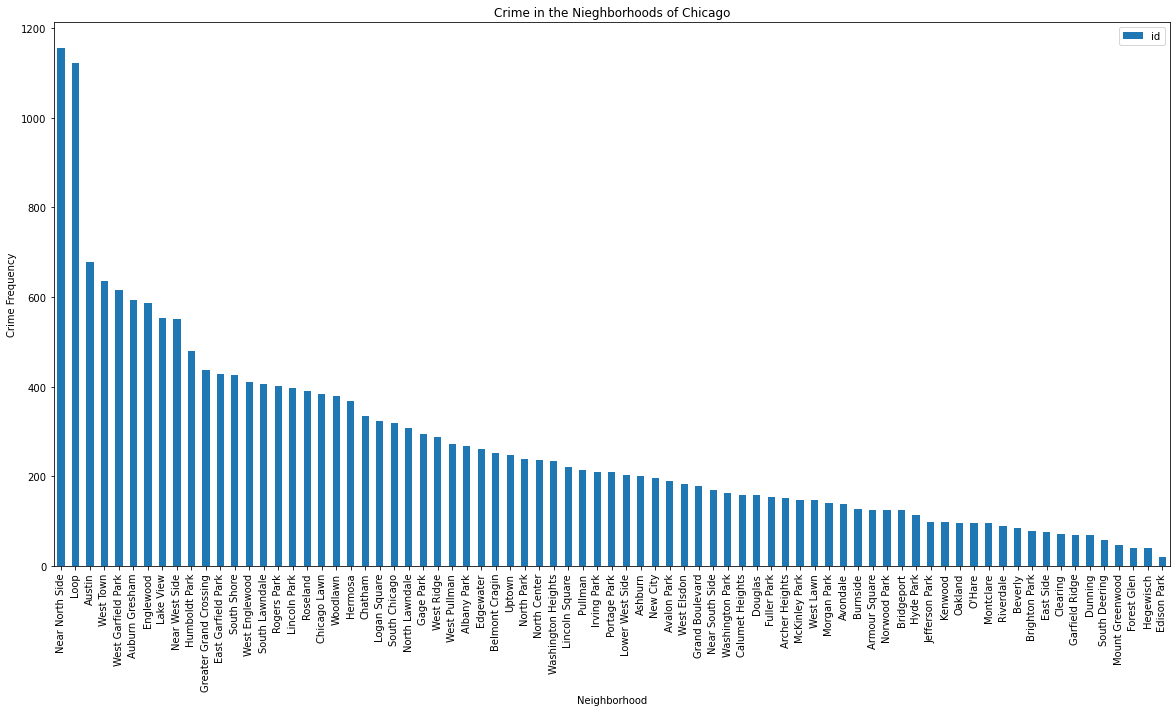

In [68]:
df_crime_c_neigh = df_crime_c[['Neighborhood','id']].groupby('Neighborhood').count()
df_crime_c_neigh.sort_values('id',axis=0,ascending=False, inplace=True)
ax5 = df_crime_c_neigh.plot(kind='bar',figsize=(20,10))
ax5.set_title('Crime in the Nieghborhoods of Chicago')
ax5.set_xlabel('Neighborhood')
ax5.set_ylabel('Crime Frequency')

In [69]:
percentage_c = []
total_c = df_crime_c_neigh['id'].sum()
for x in df_crime_c_neigh['id']:
    percent = float(x/total_c)
    percentage_c.append(percent)

In [70]:
df_crime_c_neigh['ratio'] = percentage_c
df_crime_c_neigh.reset_index(inplace=True)
df_crime_c_neigh.head()

,Neighborhood,id,ratio
0,Near North Side,1155,0.055997
1,Loop,1123,0.054446
2,Austin,677,0.032823
3,West Town,636,0.030835
4,West Garfield Park,615,0.029817


#### **New York City**

In [71]:
n_crime_neigh_column = []
count = 0
for latx,lngx in zip(df_crime_n['Latitude'],df_crime_n['Longitude']):
    crime_loc = (latx,lngx)
    minimum = []
    minimum_neigh = []
    for neigh,laty,lngy in zip(df_ny['Neighborhood'],df_ny['Latitude'],df_ny['Longitude']):
        neigh_loc = (laty,lngy)
        minimum.append(geodesic(crime_loc,neigh_loc).km)
        minimum_neigh.append(neigh)
    index, value = min(enumerate(minimum), key=operator.itemgetter(1))
    n_crime_neigh_column.append(minimum_neigh[index])
    count += 1
    if count % 2000 == 0:
        print(count)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000


In [72]:
df_crime_n['Neighborhood'] = n_crime_neigh_column
df_crime_n.head()

,id,date,primary,Latitude,Longitude,Neighborhood
8,191753721,01/02/2019,PETIT LARCENY,40.756192,-73.986256,Chelsea / Clinton / Midtown
10,191739539,01/02/2019,FORGERY,40.826097,-73.861208,Soundview / Parkchester
11,191762642,01/02/2019,ROBBERY,40.602630,-73.749563,Rockaways
12,191756715,01/02/2019,PETIT LARCENY,40.713561,-74.009910,Greenwich Village / Financial District
13,191748730,01/02/2019,POSSESSION OF STOLEN PROPERTY,40.753971,-73.986979,Chelsea / Clinton / Midtown


Text(0, 0.5, 'Frequency')

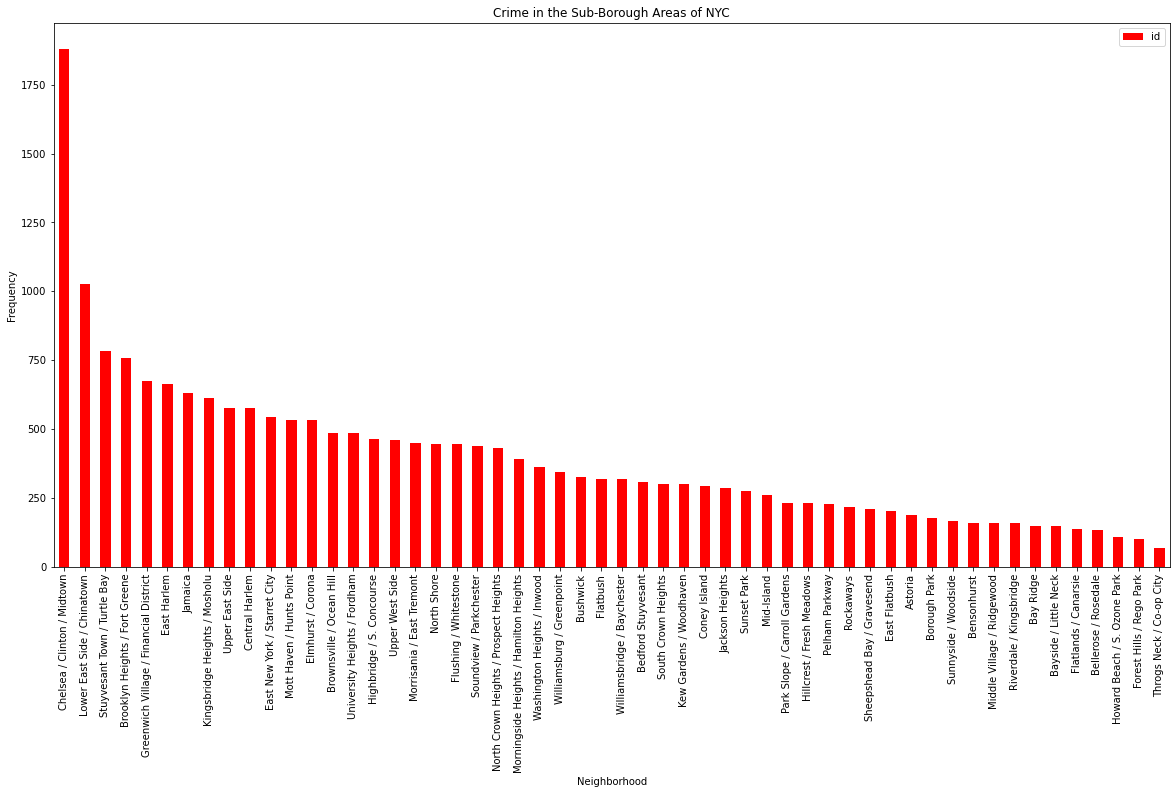

In [73]:
df_crime_n_neigh = df_crime_n[['Neighborhood','id']].groupby('Neighborhood').count()
df_crime_n_neigh.sort_values('id',axis=0,ascending=False, inplace=True)
ax6 = df_crime_n_neigh.plot(kind='bar',figsize=(20,10), color='red')
ax6.set_title('Crime in the Sub-Borough Areas of NYC')
ax6.set_xlabel('Neighborhood')
ax6.set_ylabel('Frequency')

In [74]:
percentage_n = []
total_n = df_crime_n_neigh['id'].sum()
for x in df_crime_n_neigh['id']:
    percent = float(x/total_n)
    percentage_n.append(percent)

In [75]:
df_crime_n_neigh['ratio'] = percentage_n
df_crime_n_neigh.reset_index(inplace=True)
df_crime_n_neigh.head()

,Neighborhood,id,ratio
0,Chelsea / Clinton / Midtown,1880,0.088923
1,Lower East Side / Chinatown,1025,0.048482
2,Stuyvesant Town / Turtle Bay,784,0.037083
3,Brooklyn Heights / Fort Greene,757,0.035806
4,Greenwich Village / Financial District,676,0.031974


## Demographic Data

Demographic data for Chicago and NYC were collected from the US Census Bureau and compiled from various sources.
* Chicago: [Population and Ethnicity](http://3ia2qo49aq3t30ap983kxt9x-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/Census-Data-by-Chicago-Community-Area-2018.xlsx), [Unemployment and Poverty Rate](https://data.cityofchicago.org/Health-Human-Services/Poverty-Indicators-by-COmmunity-Area/c44j-fgcy), and [PCI and Population aged 25 without High School Diploma](https://data.cityofchicago.org/Health-Human-Services/Per-Capita-Income/r6ad-wvtk)
* New York: [NYU Furman Center CoreData.nyc](app.coredata.nyc/visit)

The data has been compiled into CSV files: `chicago_demographics.csv` and `nyc_demographics.csv` which are included in the Github repository

#### **Chicago**

In [76]:
df_demo_c = pd.read_csv('chicago_demographics.csv')
df_demo_c.rename(columns={'Community Area Name':'Neighborhood'}, inplace=True)
df_demo_c.drop(index=df_demo_c.index[-1], inplace=True)
df_demo_c.loc[17,'Neighborhood'] = 'Montclare'
df_demo_c.head()

,Neighborhood,unemployment,poverty rate,population,pop aged 25 without hsd,asian_pop,black_pop,hispanic_pop,white_pop,other_pop,pci
0,Rogers Park,0.075,0.227,53346,0.182,0.043227,0.238012,0.240355,0.448543,0.029862,23939
1,West Ridge,0.079,0.151,77074,0.208,0.214755,0.128682,0.202117,0.408802,0.045644,23040
2,Uptown,0.077,0.227,55042,0.118,0.106010,0.178355,0.158315,0.526471,0.030849,35787
3,Lincoln Square,0.068,0.095,47927,0.134,0.103094,0.068124,0.176915,0.610992,0.040875,37524
4,North Center,0.045,0.071,36157,0.045,0.044805,0.086622,0.099649,0.730232,0.038692,57123


#### **New York City**

In [77]:
df_demo_n = pd.read_csv('nyc_demographics.csv')
df_demo_n.rename(columns={'Sub-Borough Area':'Neighborhood'}, inplace=True)
df_demo_n.head()

,Neighborhood,unemployment,poverty rate,population,pop aged 25 without hsd,asian_pop,black_pop,hispanic_pop,white_pop,other_pop,median income
0,Astoria,0.059342,0.149257,171100,0.140745,0.154099,0.067739,0.267112,0.480503,0.030547,64569.48051
1,Bay Ridge,0.060594,0.163629,123691,0.182881,0.250729,0.020173,0.171766,0.535353,0.021979,68877.27333
2,Bayside / Little Neck,0.045744,0.080287,117271,0.117773,0.438910,0.019587,0.116965,0.401430,0.023108,83002.87339
3,Bedford Stuyvesant,0.087078,0.284157,145895,0.179234,0.032716,0.494498,0.187020,0.262244,0.023522,48657.07822
4,Bensonhurst,0.067998,0.184279,191525,0.256549,0.403927,0.010737,0.158654,0.404201,0.022481,53834.77753


_Note that, for NYC, we are looking at sub-borough areas instead of neighborhoods (the only data that was available), and we have median income instead of PCI, for individual city clustering, this will not be an issue, however when we perform the regression analysis, we will have to drop the income columns_

# Data Exploration

Let's visualize some of the data we've collected.

### Venue Categories

We'll start with the top 100 venue categories in each city

#### **Chicago**

Text(0, 0.5, 'Frequency')

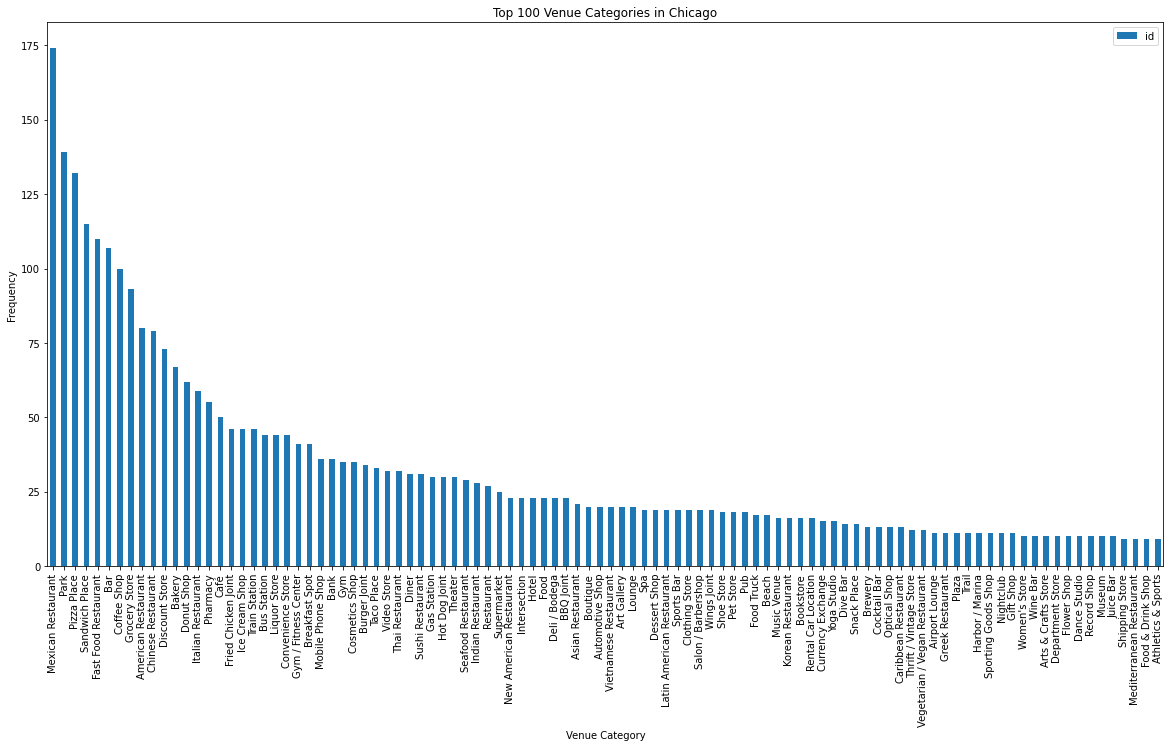

In [78]:
c_venue_count_bycat = c_venues[['Venue Category','id']].groupby('Venue Category').count()
c_venue_count_bycat.sort_values('id',axis=0, ascending=False, inplace=True)
ax7 = c_venue_count_bycat.head(100).plot(kind='bar',figsize=(20,10))
ax7.set_title('Top 100 Venue Categories in Chicago')
ax7.set_xlabel('Venue Category')
ax7.set_ylabel('Frequency')

Mexican Restaurants are always the most popular venue in Chicago.

#### **New York City**

Text(0, 0.5, 'Frequency')

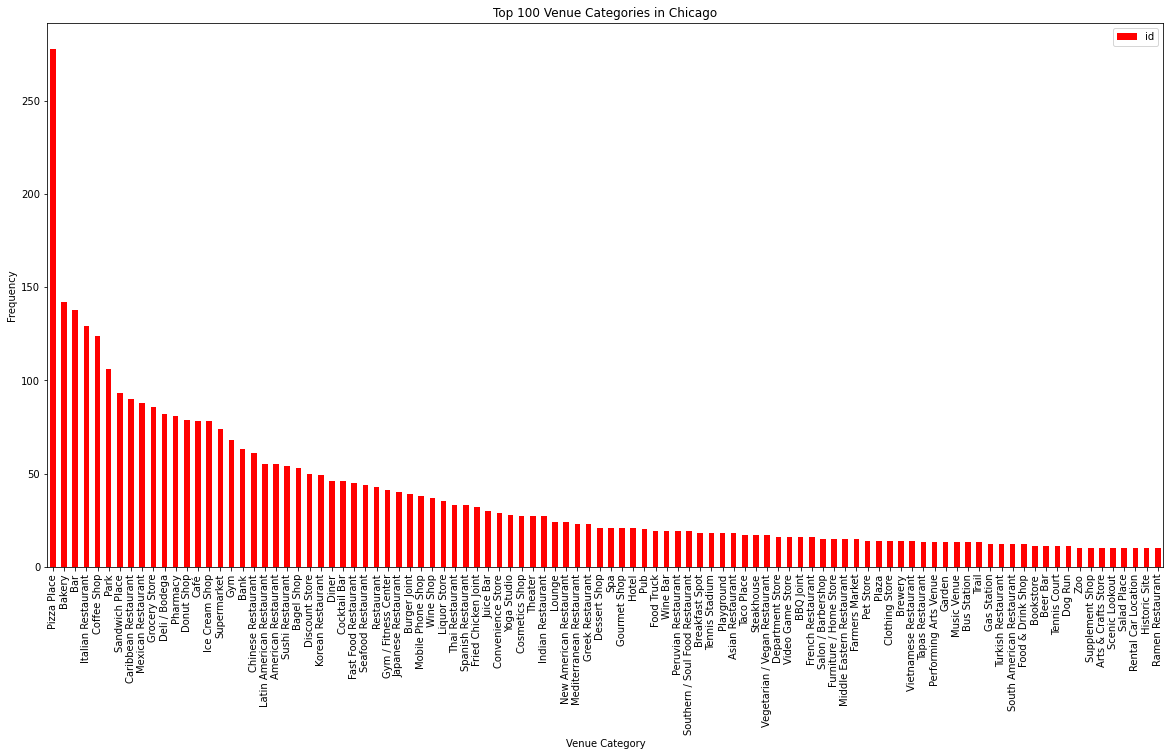

In [79]:
n_venue_count_bycat = ny_venues[['Venue Category','id']].groupby('Venue Category').count()
n_venue_count_bycat.sort_values('id',axis=0, ascending=False, inplace=True)
ax7 = n_venue_count_bycat.head(100).plot(kind='bar',figsize=(20,10), color='red')
ax7.set_title('Top 100 Venue Categories in Chicago')
ax7.set_xlabel('Venue Category')
ax7.set_ylabel('Frequency')

And Pizza Places are by far the most popular venue in NYC, more than double of Coffee Shops and Italian Restaurants.

# Data Pre-Processing

Before we can cluster the data, we need to merge our dataframes and standardize the data. For our categorical variables i.e., Venue and Crime categories, this includes one-hot encoding.

Let's simplify the process with a function for one-hot encoding

In [82]:
def onehot_encoder(df, cat):
    dummy = pd.get_dummies(df[[cat]], prefix="", prefix_sep="")
    dummy['Neighborhood'] = df['Neighborhood']
    first = dummy['Neighborhood']
    dummy.drop(['Neighborhood'], axis=1, inplace=True)
    dummy.insert(0, 'Neighborhood', first)
    dummy = dummy.groupby('Neighborhood').mean().reset_index()
    return dummy

And another function to sort most popular categories

In [83]:
def return_most_common_venues(row, num):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num]

In [84]:
num = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num):
    try:
        columns.append('{}{}'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th'.format(ind+1))

#### **Chicago**

One-hot encoding for `c_venues` and `df_crime_c`

In [85]:
c_venue_dummy = onehot_encoder(c_venues,'Venue Category')
c_venue_dummy.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Casino,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,College Rec Center,College Stadium,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lighthouse,Lighting Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recycling Facility,Rental Car Location,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Souther

In [86]:
c_crime_dummy = onehot_encoder(df_crime_c,'primary')
c_crime_dummy.head()

,Neighborhood,ARSON,BURGLARY,CRIMINAL DAMAGE,CRIMINAL TRESPASS,ROBBERY,THEFT
0,Albany Park,0.011236,0.131086,0.269663,0.014981,0.059925,0.513109
1,Archer Heights,0.019868,0.178808,0.231788,0.033113,0.052980,0.483444
2,Armour Square,0.000000,0.064000,0.152000,0.056000,0.104000,0.624000
3,Ashburn,0.010000,0.160000,0.235000,0.050000,0.090000,0.455000
4,Auburn Gresham,0.000000,0.119529,0.297980,0.063973,0.101010,0.417508


And sorting venues for cluster analysis

In [87]:
c_venue_sorted = pd.DataFrame(columns=columns)
c_venue_sorted['Neighborhood'] = c_venue_dummy['Neighborhood']

for ind in np.arange(c_venue_dummy.shape[0]):
    c_venue_sorted.iloc[ind, 1:] = return_most_common_venues(c_venue_dummy.iloc[ind, :], num)

c_venue_sorted.head()

,Neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,Albany Park,Mexican Restaurant,Pizza Place,Grocery Store,Discount Store,Donut Shop,Sandwich Place,Mobile Phone Shop,Chinese Restaurant,Hookah Bar,Korean Restaurant
1,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Grocery Store,Fast Food Restaurant,Bank,Coffee Shop,Eastern European Restaurant,Clothing Store,Rental Car Location,Bakery
2,Armour Square,Chinese Restaurant,Pizza Place,Bar,Park,Bus Station,Gym / Fitness Center,Szechuan Restaurant,Grocery Store,Italian Restaurant,Business Service
3,Ashburn,Park,Pizza Place,Liquor Store,American Restaurant,Train Station,Seafood Restaurant,Fried Chicken Joint,Locksmith,Fast Food Restaurant,Clothing Store
4,Auburn Gresham,Fast Food Restaurant,Pharmacy,Park,Lounge,Currency Exchange,Discount Store,Video Store,Gas Station,BBQ Joint,Bus Station


In [88]:
num_special = 6

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns_special = ['Neighborhood']
for ind in np.arange(num_special):
    try:
        columns_special.append('{}{}'.format(ind+1, indicators[ind]))
    except:
        columns_special.append('{}th'.format(ind+1))

In [89]:
c_crime_sorted = pd.DataFrame(columns=columns_special)
c_crime_sorted['Neighborhood'] = c_crime_dummy['Neighborhood']

for ind in np.arange(c_crime_dummy.shape[0]):
    c_crime_sorted.iloc[ind, 1:] = return_most_common_venues(c_crime_dummy.iloc[ind, :], num_special)

c_crime_sorted.head()

,Neighborhood,1st,2nd,3rd,4th,5th,6th
0,Albany Park,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
1,Archer Heights,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
2,Armour Square,THEFT,CRIMINAL DAMAGE,ROBBERY,BURGLARY,CRIMINAL TRESPASS,ARSON
3,Ashburn,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
4,Auburn Gresham,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON


Dropping `Neighborhood` columns for clustering

In [90]:
c_venue_dummy.drop(columns=['Neighborhood'], inplace=True)
c_crime_dummy.drop(columns=['Neighborhood'], inplace=True)

#### **New York**

One-hot encoding for `ny_venues` and `df_crime_n`

In [91]:
n_venue_dummy = onehot_encoder(ny_venues,'Venue Category')
n_venue_dummy.head()

,Neighborhood,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Reservoir,Resort,Rest Area,Restaurant,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Stor

In [92]:
n_crime_dummy = onehot_encoder(df_crime_n,'primary')
n_crime_dummy.head()

,Neighborhood,ARSON,BURGLAR'S TOOLS,BURGLARY,CRIMINAL TRESPASS,FORGERY,FRAUDS,GRAND LARCENY,OFFENSES INVOLVING FRAUD,OTHER OFFENSES RELATED TO THEF,PETIT LARCENY,POSSESSION OF STOLEN PROPERTY,ROBBERY,THEFT OF SERVICES,THEFT-FRAUD
0,Astoria,0.000000,0.010753,0.107527,0.053763,0.043011,0.026882,0.193548,0.016129,0.026882,0.333333,0.037634,0.150538,0.000000,0.000000
1,Bay Ridge,0.000000,0.026846,0.026846,0.067114,0.100671,0.020134,0.080537,0.020134,0.026846,0.402685,0.073826,0.154362,0.000000,0.000000
2,Bayside / Little Neck,0.006803,0.013605,0.122449,0.020408,0.040816,0.034014,0.244898,0.013605,0.013605,0.231293,0.040816,0.204082,0.000000,0.013605
3,Bedford Stuyvesant,0.000000,0.019417,0.119741,0.038835,0.122977,0.022654,0.090615,0.006472,0.064725,0.294498,0.025890,0.181230,0.012945,0.000000
4,Bellerose / Rosedale,0.000000,0.007576,0.075758,0.106061,0.219697,0.015152,0.068182,0.030303,0.015152,0.287879,0.098485,0.068182,0.000000,0.007576


Sorting categories for analysis

In [93]:
n_venue_sorted = pd.DataFrame(columns=columns)
n_venue_sorted['Neighborhood'] = n_venue_dummy['Neighborhood']

for ind in np.arange(n_venue_dummy.shape[0]):
    n_venue_sorted.iloc[ind, 1:] = return_most_common_venues(n_venue_dummy.iloc[ind, :], num)

n_venue_sorted.head()

,Neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,Astoria,Greek Restaurant,Bar,Deli / Bodega,Pizza Place,Italian Restaurant,Restaurant,Indian Restaurant,Seafood Restaurant,Bakery,Bagel Shop
1,Bay Ridge,Pizza Place,Italian Restaurant,Bagel Shop,Spa,Bar,Bakery,Coffee Shop,Greek Restaurant,American Restaurant,Turkish Restaurant
2,Bayside / Little Neck,Korean Restaurant,Bar,Bakery,Coffee Shop,Sandwich Place,Trail,Yoga Studio,Chinese Restaurant,Sushi Restaurant,American Restaurant
3,Bedford Stuyvesant,Bar,Coffee Shop,Caribbean Restaurant,Wine Shop,Bakery,Pizza Place,Deli / Bodega,Café,Juice Bar,French Restaurant
4,Bellerose / Rosedale,Caribbean Restaurant,Pharmacy,Supermarket,Donut Shop,Fast Food Restaurant,Pizza Place,Moving Target,Fried Chicken Joint,Restaurant,Cosmetics Shop


In [94]:
n_crime_sorted = pd.DataFrame(columns=columns)
n_crime_sorted['Neighborhood'] = n_crime_dummy['Neighborhood']

for ind in np.arange(n_crime_dummy.shape[0]):
    n_crime_sorted.iloc[ind, 1:] = return_most_common_venues(n_crime_dummy.iloc[ind, :], num)

n_crime_sorted.head()

,Neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,Astoria,PETIT LARCENY,GRAND LARCENY,ROBBERY,BURGLARY,CRIMINAL TRESPASS,FORGERY,POSSESSION OF STOLEN PROPERTY,OTHER OFFENSES RELATED TO THEF,FRAUDS,OFFENSES INVOLVING FRAUD
1,Bay Ridge,PETIT LARCENY,ROBBERY,FORGERY,GRAND LARCENY,POSSESSION OF STOLEN PROPERTY,CRIMINAL TRESPASS,OTHER OFFENSES RELATED TO THEF,BURGLARY,BURGLAR'S TOOLS,OFFENSES INVOLVING FRAUD
2,Bayside / Little Neck,GRAND LARCENY,PETIT LARCENY,ROBBERY,BURGLARY,POSSESSION OF STOLEN PROPERTY,FORGERY,FRAUDS,CRIMINAL TRESPASS,THEFT-FRAUD,OTHER OFFENSES RELATED TO THEF
3,Bedford Stuyvesant,PETIT LARCENY,ROBBERY,FORGERY,BURGLARY,GRAND LARCENY,OTHER OFFENSES RELATED TO THEF,CRIMINAL TRESPASS,POSSESSION OF STOLEN PROPERTY,FRAUDS,BURGLAR'S TOOLS
4,Bellerose / Rosedale,PETIT LARCENY,FORGERY,CRIMINAL TRESPASS,POSSESSION OF STOLEN PROPERTY,BURGLARY,ROBBERY,GRAND LARCENY,OFFENSES INVOLVING FRAUD,OTHER OFFENSES RELATED TO THEF,FRAUDS


Dropping `Neighborhood` for clustering

In [95]:
n_venue_dummy.drop(columns=['Neighborhood'], inplace=True)
n_crime_dummy.drop(columns=['Neighborhood'], inplace=True)

# kMeans Clustering

For the clustering, we need to choose the number of centres the algorithm uses to predict the clusters for the neighborhoods, for our anlysis we will be using _k_ = 5 for all the clustering we do, close enough to the actual optimal _k_ but consistent enough across all datasets for the regression analysis. 

We'll also create a function to simplify the process of k-Clustering

In [97]:
def kclustering(df,k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
    return kmeans.labels_

Our _k_:

In [98]:
k_clusters = 5

A function to create maps from the cluster labels

In [99]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [100]:
def clustermapper(k,locate,df_merged):
    map_clusters = folium.Map(location=[locate[0],locate[1]], zoom_start=10)
    x = np.arange(k)
    ys = [i + x + (i*x)**2 for i in range(k)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Clusters']):
        cluster = int(cluster)
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
           
    return map_clusters    

#### **Chicago**

We merge our location dataset with the sorted venues, and add the cluster labels from the clustering function for the mapping

In [101]:
c_merged_venue = df_c
c_merged_venue = c_merged_venue.join(c_venue_sorted.set_index('Neighborhood'), on='Neighborhood')
c_merged_venue.insert(0, 'Clusters', kclustering(c_venue_dummy, k_clusters))
c_merged_venue.head()

,Clusters,Neighborhood,Latitude,Longitude,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,4,Rogers Park,42.010311,-87.670135,Mexican Restaurant,Sandwich Place,Pizza Place,Bar,Park,American Restaurant,Coffee Shop,Beach,Sushi Restaurant,Theater
1,4,West Ridge,42.003090,-87.694931,Indian Restaurant,Grocery Store,Park,Pakistani Restaurant,Fast Food Restaurant,Boutique,Korean Restaurant,Dessert Shop,Mexican Restaurant,Bookstore
2,3,Uptown,41.967789,-87.652428,Vietnamese Restaurant,Coffee Shop,Mexican Restaurant,Chinese Restaurant,Park,Sushi Restaurant,Thai Restaurant,Grocery Store,Bar,Bakery
3,1,Lincoln Square,41.974934,-87.687935,Bar,Thai Restaurant,Café,Sandwich Place,Gym,Gourmet Shop,Karaoke Bar,New American Restaurant,Dive Bar,Sushi Restaurant
4,0,North Center,41.946815,-87.683388,Bar,Mexican Restaurant,Sushi Restaurant,Coffee Shop,Bakery,Boutique,Music Venue,Pizza Place,Beer Garden,Grocery Store


Do the same for sorted crimes

In [102]:
c_merged_crime = df_c
c_merged_crime = c_merged_crime.join(c_crime_sorted.set_index('Neighborhood'), on='Neighborhood')
c_merged_crime.insert(0, 'Clusters', kclustering(c_crime_dummy, k_clusters))
c_merged_crime.head()

,Clusters,Neighborhood,Latitude,Longitude,1st,2nd,3rd,4th,5th,6th
0,3,Rogers Park,42.010311,-87.670135,THEFT,CRIMINAL DAMAGE,BURGLARY,CRIMINAL TRESPASS,ROBBERY,ARSON
1,2,West Ridge,42.003090,-87.694931,THEFT,CRIMINAL DAMAGE,BURGLARY,CRIMINAL TRESPASS,ROBBERY,ARSON
2,1,Uptown,41.967789,-87.652428,THEFT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,ROBBERY,BURGLARY,ARSON
3,2,Lincoln Square,41.974934,-87.687935,THEFT,CRIMINAL DAMAGE,BURGLARY,CRIMINAL TRESPASS,ROBBERY,ARSON
4,0,North Center,41.946815,-87.683388,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON


And, finally mapping them

In [103]:
# Chicago
map_c_venue_clusters = clustermapper(k_clusters,location1,c_merged_venue)
map_c_venue_clusters

In [104]:
# Chicago
map_c_crime_clusters = clustermapper(k_clusters,location1,c_merged_crime)
map_c_crime_clusters

#### **New York City**

We do the same for NYC venues

In [105]:
n_merged_venue = df_ny
n_merged_venue = n_merged_venue.join(n_venue_sorted.set_index('Neighborhood'), on='Neighborhood')
n_merged_venue.insert(0, 'Clusters', kclustering(n_venue_dummy, k_clusters))
n_merged_venue.head()

,Clusters,Neighborhood,Latitude,Longitude,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,3,North Shore,40.625868,-74.121420,Pizza Place,Bagel Shop,Ice Cream Shop,Chinese Restaurant,American Restaurant,Sandwich Place,Italian Restaurant,Bank,Convenience Store,Board Shop
1,3,East Harlem,40.797080,-73.937853,Park,Pizza Place,Coffee Shop,Burger Joint,Mexican Restaurant,Thai Restaurant,Cocktail Bar,Fountain,Café,Wine Bar
2,3,Mid-Island,40.591955,-74.139206,Bus Stop,Trail,Campground,Sandwich Place,Historic Site,Gym / Fitness Center,Coffee Shop,College Arts Building,Bowling Alley,Deli / Bodega
4,3,Washington Heights / Inwood,40.839632,-73.942751,Latin American Restaurant,Deli / Bodega,Bakery,Coffee Shop,Park,Bar,Mexican Restaurant,Bookstore,Sushi Restaurant,Café
5,1,Astoria,40.771347,-73.910056,Greek Restaurant,Bar,Deli / Bodega,Pizza Place,Italian Restaurant,Restaurant,Indian Restaurant,Seafood Restaurant,Bakery,Bagel Shop


And crimes

In [106]:
n_merged_crime = df_ny
n_merged_crime = n_merged_crime.join(n_crime_sorted.set_index('Neighborhood'), on='Neighborhood')
n_merged_crime.insert(0, 'Clusters', kclustering(n_crime_dummy, k_clusters))
n_merged_crime.head()

,Clusters,Neighborhood,Latitude,Longitude,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,0,North Shore,40.625868,-74.121420,PETIT LARCENY,GRAND LARCENY,ROBBERY,BURGLARY,FORGERY,CRIMINAL TRESPASS,POSSESSION OF STOLEN PROPERTY,THEFT-FRAUD,OTHER OFFENSES RELATED TO THEF,FRAUDS
1,0,East Harlem,40.797080,-73.937853,PETIT LARCENY,ROBBERY,FORGERY,GRAND LARCENY,OTHER OFFENSES RELATED TO THEF,CRIMINAL TRESPASS,BURGLARY,OFFENSES INVOLVING FRAUD,POSSESSION OF STOLEN PROPERTY,FRAUDS
2,1,Mid-Island,40.591955,-74.139206,PETIT LARCENY,GRAND LARCENY,POSSESSION OF STOLEN PROPERTY,CRIMINAL TRESPASS,BURGLARY,ROBBERY,OTHER OFFENSES RELATED TO THEF,FORGERY,OFFENSES INVOLVING FRAUD,FRAUDS
4,1,Washington Heights / Inwood,40.839632,-73.942751,PETIT LARCENY,ROBBERY,BURGLARY,GRAND LARCENY,FORGERY,CRIMINAL TRESPASS,OTHER OFFENSES RELATED TO THEF,POSSESSION OF STOLEN PROPERTY,FRAUDS,OFFENSES INVOLVING FRAUD
5,4,Astoria,40.771347,-73.910056,PETIT LARCENY,GRAND LARCENY,ROBBERY,BURGLARY,CRIMINAL TRESPASS,FORGERY,POSSESSION OF STOLEN PROPERTY,OTHER OFFENSES RELATED TO THEF,FRAUDS,OFFENSES INVOLVING FRAUD


And mapping

In [107]:
# New York City
map_n_venue_clusters = clustermapper(k_clusters,location2,n_merged_venue)
map_n_venue_clusters

In [108]:
# New York City
map_n_crime_clusters = clustermapper(k_clusters,location2,n_merged_crime)
map_n_crime_clusters

## Let's inspect the clusters in detail

#### **Chicago**

### Venues

In [109]:
c_venue_cluster_count = n_merged_venue[['Clusters','Neighborhood']].groupby('Clusters').count()
c_venue_cluster_count.rename(columns={'Neighborhood':'count'}, inplace=True)
c_venue_cluster_count.sort_values('count', axis=0, ascending=False, inplace=True)
c_venue_cluster_count.head()

,count
Clusters,
3,25
0,22
1,5
2,1
4,1


The most populated cluster is Cluster 4 (3 in the dataframe)

#### Cluster 1

In [110]:
c_merged_venue.loc[c_merged_venue['Clusters'] == 0, c_merged_venue.columns[[1] + list(range(4, c_merged_venue.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
North Center,Bar,Mexican Restaurant,Sushi Restaurant,Coffee Shop,Bakery,Boutique,Music Venue,Pizza Place,Beer Garden,Grocery Store
Lake View,Gay Bar,Bar,Taco Place,General Entertainment,Ice Cream Shop,Mexican Restaurant,Baseball Stadium,Pizza Place,Café,Sandwich Place
Lincoln Park,Coffee Shop,Pizza Place,Italian Restaurant,Bakery,Gym / Fitness Center,American Restaurant,Café,Mexican Restaurant,Burger Joint,Sushi Restaurant
North Park,Zoo Exhibit,Bar,Comedy Club,American Restaurant,Trail,Gym / Fitness Center,Gym,Grocery Store,Italian Restaurant,Dessert Shop
Albany Park,Mexican Restaurant,Pizza Place,Grocery Store,Discount Store,Donut Shop,Sandwich Place,Mobile Phone Shop,Chinese Restaurant,Hookah Bar,Korean Restaurant
Portage Park,Pizza Place,Italian Restaurant,Mexican Restaurant,Convenience Store,Pharmacy,Ice Cream Shop,Grocery Store,Dance Studio,Clothing Store,Miscellaneous Shop
Irving Park,Bus Station,Sandwich Place,Pizza Place,Convenience Store,Café,Theater,Bank,Chinese Restaurant,Bar,Automotive Shop
Hermosa,Mexican Restaurant,Discount Store,Pizza Place,Donut Shop,Cuban Restaurant,Pharmacy,Mobile Phone Shop,Fast Food Restaurant,Sandwich Place,Supermarket
West Town,Coffee Shop,Pizza Place,Café,Bar,Sushi Restaurant,Salon / Barbershop,Italian Restaurant,Taco Place,Dive Bar,Bakery


The most popular places in Cluster 1 seem to consist of mostly Fast Food, Mexican Restaurant, and Bars and Cafés.

#### Cluster 2

In [111]:
c_merged_venue.loc[c_merged_venue['Clusters'] == 1, c_merged_venue.columns[[1] + list(range(4, c_merged_venue.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Lincoln Square,Bar,Thai Restaurant,Café,Sandwich Place,Gym,Gourmet Shop,Karaoke Bar,New American Restaurant,Dive Bar,Sushi Restaurant
Montclare,Fast Food Restaurant,Pizza Place,Grocery Store,Park,Mexican Restaurant,Breakfast Spot,Gas Station,Bakery,Bank,Bar
Austin,Fast Food Restaurant,Discount Store,Sandwich Place,Grocery Store,BBQ Joint,Donut Shop,Bus Station,Salon / Barbershop,Fried Chicken Joint,Liquor Store
West Garfield Park,Fast Food Restaurant,Shoe Store,Sandwich Place,Fried Chicken Joint,Train Station,ATM,Record Shop,Liquor Store,Gas Station,BBQ Joint
North Lawndale,Fast Food Restaurant,Bus Station,Shoe Store,Food Truck,Liquor Store,Bike Rental / Bike Share,Food,Currency Exchange,Metro Station,Soccer Field
South Lawndale,Mexican Restaurant,Bakery,Ice Cream Shop,Bank,Taco Place,Nightclub,Gym / Fitness Center,Liquor Store,Fast Food Restaurant,Mobile Phone Shop
Burnside,Food Service,Intersection,Convenience Store,Park,Fast Food Restaurant,Bus Station,Breakfast Spot,Southern / Soul Food Restaurant,Liquor Store,Gym
Hegewisch,Bar,Fishing Spot,Greek Restaurant,Market,Park,Discount Store,Intersection,State / Provincial Park,American Restaurant,Chinese Restaurant
Archer Heights,Mexican Restaurant,Mobile Phone Shop,Grocery Store,Fast Food Restaurant,Bank,Coffee Shop,Eastern European Restaurant,Clothing Store,Rental Car Location,Bakery


Cluster 2 is similar to Cluster 1 however it seems to also include locations like Bus & Train Stations, Banks, ATMs, and leisure locations such as Parks and Soccer Fields

#### Cluster 3

In [112]:
c_merged_venue.loc[c_merged_venue['Clusters'] == 2, c_merged_venue.columns[[1] + list(range(4, c_merged_venue.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Bridgeport,Art Gallery,Chinese Restaurant,Bar,Pizza Place,Mexican Restaurant,Grocery Store,Wings Joint,Bakery,Pharmacy,Coffee Shop


Cluster 3 is the smallest cluster with only one neighborhood

#### Cluster 4

In [113]:
c_merged_venue.loc[c_merged_venue['Clusters'] == 3, c_merged_venue.columns[[1] + list(range(4, c_merged_venue.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Uptown,Vietnamese Restaurant,Coffee Shop,Mexican Restaurant,Chinese Restaurant,Park,Sushi Restaurant,Thai Restaurant,Grocery Store,Bar,Bakery
Near North Side,Hotel,Steakhouse,American Restaurant,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Gym,Lounge,New American Restaurant,Massage Studio
Norwood Park,Park,Pizza Place,American Restaurant,Chinese Restaurant,Automotive Shop,Gas Station,Fried Chicken Joint,Sports Bar,Food,Mexican Restaurant
Jefferson Park,Deli / Bodega,Discount Store,Greek Restaurant,Mexican Restaurant,Chinese Restaurant,American Restaurant,Pub,Bar,Park,Convenience Store
Belmont Cragin,Mexican Restaurant,Sandwich Place,Chinese Restaurant,Donut Shop,Shoe Store,Fast Food Restaurant,Bakery,Pharmacy,Gas Station,American Restaurant
Logan Square,Cocktail Bar,Coffee Shop,Gym / Fitness Center,Bar,Bakery,Italian Restaurant,Art Gallery,Grocery Store,Café,Mexican Restaurant
Humboldt Park,Latin American Restaurant,Caribbean Restaurant,Discount Store,Liquor Store,Bar,Park,Sandwich Place,Furniture / Home Store,Flower Shop,Deli / Bodega
Near South Side,Harbor / Marina,Bar,American Restaurant,Park,Coffee Shop,Pizza Place,Gym,Historic Site,Burger Joint,Hotel
Armour Square,Chinese Restaurant,Pizza Place,Bar,Park,Bus Station,Gym / Fitness Center,Szechuan Restaurant,Grocery Store,Italian Restaurant,Business Service


Cluster 4 mainly consists of Parks, Hotels, Delis, Beaches and Gyms. And as expected, Cluster 4 neighborhoods mainly exist along the coast of Chicago

#### Cluster 5

In [114]:
c_merged_venue.loc[c_merged_venue['Clusters'] == 4, c_merged_venue.columns[[1] + list(range(4, c_merged_venue.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Rogers Park,Mexican Restaurant,Sandwich Place,Pizza Place,Bar,Park,American Restaurant,Coffee Shop,Beach,Sushi Restaurant,Theater
West Ridge,Indian Restaurant,Grocery Store,Park,Pakistani Restaurant,Fast Food Restaurant,Boutique,Korean Restaurant,Dessert Shop,Mexican Restaurant,Bookstore
Edison Park,Italian Restaurant,Bar,Salon / Barbershop,Park,Pizza Place,Bakery,Grocery Store,Automotive Shop,Thrift / Vintage Store,Spa
Forest Glen,Park,Sandwich Place,Trail,Golf Course,Coffee Shop,Grocery Store,Fast Food Restaurant,Gas Station,Salon / Barbershop,Thai Restaurant
Dunning,Fast Food Restaurant,Shoe Store,Cosmetics Shop,Bar,Donut Shop,Supplement Shop,Automotive Shop,Ice Cream Shop,Eastern European Restaurant,Park
Avondale,Bar,Coffee Shop,Mexican Restaurant,Donut Shop,Grocery Store,Café,Chinese Restaurant,Breakfast Spot,Dance Studio,Art Gallery
East Garfield Park,Park,Train Station,American Restaurant,Pharmacy,Food,Diner,Liquor Store,Bakery,Basketball Court,Supermarket
Near West Side,Sandwich Place,Italian Restaurant,Bar,Thai Restaurant,Breakfast Spot,Sports Bar,Pizza Place,Park,Coffee Shop,Mexican Restaurant
Lower West Side,Mexican Restaurant,Bakery,Bar,Pizza Place,Latin American Restaurant,Taco Place,Park,Ice Cream Shop,Cocktail Bar,Coffee Shop


Cluster 5 conists mainly of Mexican Restaurants, Parks, Bars and Groceries

### Crimes

In [115]:
c_crime_cluster_count = c_merged_crime[['Clusters','Neighborhood']].groupby('Clusters').count()
c_crime_cluster_count.rename(columns={'Neighborhood':'count'}, inplace=True)
c_crime_cluster_count.sort_values('count', axis=0, ascending=False, inplace=True)
c_crime_cluster_count.head()

,count
Clusters,
3,21
1,18
0,16
2,13
4,9


Cluster sizes for crimes are similar to that of venues with CLuster 4 being the largest (3 in the dataframe)

With only 6 crime categories available for analysis, interpretation is a little easier. Theft and Criminal Damage are the top 2 crimes in almost every neighborhood followed by either Burglary or Robbery in 3rd and 4th. Arson is almost always the least occuring crime, which is as expected due to its low occurence in the entire crime dataset, except in Hermosa in Cluster 4 where it is the 5th most occuring.

#### Cluster 1

In [116]:
c_merged_crime.loc[c_merged_crime['Clusters'] == 0, c_merged_crime.columns[[1] + list(range(4, c_merged_crime.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th
Neighborhood,,,,,,
North Center,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
Lake View,THEFT,CRIMINAL DAMAGE,BURGLARY,CRIMINAL TRESPASS,ROBBERY,ARSON
Lincoln Park,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
North Park,THEFT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,ROBBERY,BURGLARY,ARSON
Irving Park,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
Dunning,THEFT,CRIMINAL DAMAGE,BURGLARY,CRIMINAL TRESPASS,ROBBERY,ARSON
Belmont Cragin,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
South Lawndale,THEFT,CRIMINAL DAMAGE,ROBBERY,BURGLARY,CRIMINAL TRESPASS,ARSON
Chatham,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON


#### Cluster 2

In [117]:
c_merged_crime.loc[c_merged_crime['Clusters'] == 1, c_merged_crime.columns[[1] + list(range(4, c_merged_crime.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th
Neighborhood,,,,,,
Uptown,THEFT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,ROBBERY,BURGLARY,ARSON
Montclare,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
Logan Square,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
Humboldt Park,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
Armour Square,THEFT,CRIMINAL DAMAGE,ROBBERY,BURGLARY,CRIMINAL TRESPASS,ARSON
Fuller Park,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
Grand Boulevard,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
Kenwood,THEFT,CRIMINAL DAMAGE,ROBBERY,BURGLARY,CRIMINAL TRESPASS,ARSON
Hyde Park,THEFT,CRIMINAL DAMAGE,ROBBERY,BURGLARY,CRIMINAL TRESPASS,ARSON


#### Cluster 3

In [118]:
c_merged_crime.loc[c_merged_crime['Clusters'] == 2, c_merged_crime.columns[[1] + list(range(4, c_merged_crime.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th
Neighborhood,,,,,,
West Ridge,THEFT,CRIMINAL DAMAGE,BURGLARY,CRIMINAL TRESPASS,ROBBERY,ARSON
Lincoln Square,THEFT,CRIMINAL DAMAGE,BURGLARY,CRIMINAL TRESPASS,ROBBERY,ARSON
Norwood Park,THEFT,CRIMINAL DAMAGE,BURGLARY,CRIMINAL TRESPASS,ROBBERY,ARSON
Portage Park,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
Austin,THEFT,CRIMINAL DAMAGE,ROBBERY,BURGLARY,CRIMINAL TRESPASS,ARSON
West Garfield Park,THEFT,CRIMINAL DAMAGE,ROBBERY,BURGLARY,CRIMINAL TRESPASS,ARSON
Douglas,THEFT,CRIMINAL DAMAGE,ROBBERY,BURGLARY,CRIMINAL TRESPASS,ARSON
Oakland,THEFT,CRIMINAL DAMAGE,ROBBERY,BURGLARY,CRIMINAL TRESPASS,ARSON
Washington Park,THEFT,CRIMINAL DAMAGE,ROBBERY,CRIMINAL TRESPASS,BURGLARY,ARSON


#### Cluster 4

In [119]:
c_merged_crime.loc[c_merged_crime['Clusters'] == 3, c_merged_crime.columns[[1] + list(range(4, c_merged_crime.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th
Neighborhood,,,,,,
Rogers Park,THEFT,CRIMINAL DAMAGE,BURGLARY,CRIMINAL TRESPASS,ROBBERY,ARSON
Near North Side,THEFT,CRIMINAL DAMAGE,ROBBERY,CRIMINAL TRESPASS,BURGLARY,ARSON
Edison Park,THEFT,CRIMINAL TRESPASS,CRIMINAL DAMAGE,BURGLARY,ROBBERY,ARSON
Jefferson Park,THEFT,CRIMINAL DAMAGE,BURGLARY,CRIMINAL TRESPASS,ROBBERY,ARSON
Albany Park,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
Hermosa,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,ARSON,CRIMINAL TRESPASS
Near West Side,THEFT,CRIMINAL DAMAGE,ROBBERY,BURGLARY,CRIMINAL TRESPASS,ARSON
North Lawndale,THEFT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,ROBBERY,BURGLARY,ARSON
Loop,THEFT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,ROBBERY,BURGLARY,ARSON


#### Cluster 5

In [120]:
c_merged_crime.loc[c_merged_crime['Clusters'] == 4, c_merged_crime.columns[[1] + list(range(4, c_merged_crime.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th
Neighborhood,,,,,,
Forest Glen,THEFT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,BURGLARY,ROBBERY,ARSON
Avondale,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
West Town,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
East Garfield Park,THEFT,CRIMINAL DAMAGE,ROBBERY,BURGLARY,CRIMINAL TRESPASS,ARSON
Lower West Side,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
West Pullman,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
Bridgeport,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
West Elsdon,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON
Auburn Gresham,THEFT,CRIMINAL DAMAGE,BURGLARY,ROBBERY,CRIMINAL TRESPASS,ARSON


#### **New York City**

### Venues

In [121]:
n_venue_cluster_count = n_merged_venue[['Clusters','Neighborhood']].groupby('Clusters').count()
n_venue_cluster_count.rename(columns={'Neighborhood':'count'}, inplace=True)
n_venue_cluster_count.sort_values('count', axis=0, ascending=False, inplace=True)
n_venue_cluster_count.head()

,count
Clusters,
3,25
0,22
1,5
2,1
4,1


#### Cluster 1

In [122]:
n_merged_venue.loc[n_merged_venue['Clusters'] == 0, n_merged_venue.columns[[1] + list(range(4, n_merged_venue.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Jackson Heights,Latin American Restaurant,Bakery,Peruvian Restaurant,Pharmacy,South American Restaurant,Airport Lounge,Bank,Pizza Place,Spanish Restaurant,Park
Sunnyside / Woodside,Bar,Pizza Place,Mexican Restaurant,American Restaurant,Pub,Bakery,Grocery Store,Gym,Sushi Restaurant,Thai Restaurant
Elmhurst / Corona,Tennis Stadium,Bakery,Argentinian Restaurant,South American Restaurant,Pizza Place,Italian Restaurant,Mexican Restaurant,Restaurant,Empanada Restaurant,Cocktail Bar
Chelsea / Clinton / Midtown,Theater,Hotel,Coffee Shop,Gym / Fitness Center,Korean Restaurant,Bakery,Steakhouse,Cuban Restaurant,Cosmetics Shop,Boxing Gym
Howard Beach / S. Ozone Park,Pizza Place,Italian Restaurant,Ice Cream Shop,Pharmacy,Donut Shop,Chinese Restaurant,Hotel,Liquor Store,Park,Fast Food Restaurant
Bayside / Little Neck,Korean Restaurant,Bar,Bakery,Coffee Shop,Sandwich Place,Trail,Yoga Studio,Chinese Restaurant,Sushi Restaurant,American Restaurant
Upper East Side,Italian Restaurant,Bakery,Thai Restaurant,Ice Cream Shop,Coffee Shop,Bar,Sushi Restaurant,Cocktail Bar,Gym,Park
Rockaways,Pizza Place,Bagel Shop,Pharmacy,Bar,Supermarket,Sandwich Place,Mediterranean Restaurant,Bank,Seafood Restaurant,Board Shop
Greenwich Village / Financial District,Italian Restaurant,Coffee Shop,Café,Park,Sushi Restaurant,Pizza Place,Seafood Restaurant,Sandwich Place,Speakeasy,Gourmet Shop


Restaurants, Cafés and Bars decribe this cluster best

#### Cluster 2

In [123]:
n_merged_venue.loc[n_merged_venue['Clusters'] == 1, n_merged_venue.columns[[1] + list(range(4, n_merged_venue.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Astoria,Greek Restaurant,Bar,Deli / Bodega,Pizza Place,Italian Restaurant,Restaurant,Indian Restaurant,Seafood Restaurant,Bakery,Bagel Shop
Hillcrest / Fresh Meadows,Ice Cream Shop,Pizza Place,Chinese Restaurant,Japanese Restaurant,Bakery,Bank,Sushi Restaurant,Sandwich Place,Gym,Pharmacy
Mott Haven / Hunts Point,Sandwich Place,Mexican Restaurant,Pizza Place,Pharmacy,Gym,Discount Store,Donut Shop,Grocery Store,Spanish Restaurant,Mobile Phone Shop
Brownsville / Ocean Hill,Pizza Place,Discount Store,Sandwich Place,Supermarket,Gym / Fitness Center,Ice Cream Shop,Pharmacy,Grocery Store,Deli / Bodega,Southern / Soul Food Restaurant
Bensonhurst,Italian Restaurant,Sushi Restaurant,Pharmacy,Bank,Pizza Place,Bakery,Ice Cream Shop,Chinese Restaurant,Cantonese Restaurant,Supermarket


This cluster mostly contains restaurants serving quick bites, Gyms, and Banks

#### Cluster 3

In [124]:
n_merged_venue.loc[n_merged_venue['Clusters'] == 2, n_merged_venue.columns[[1] + list(range(4, n_merged_venue.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Kingsbridge Heights / Mosholu,Pizza Place,Mexican Restaurant,Gym,Diner,Donut Shop,Sandwich Place,Spanish Restaurant,Garden,Latin American Restaurant,Chinese Restaurant


There isn't a lot to decribe about this one-neighborhood cluster other than its defining Garden venue appearing in 8th place

#### Cluster 4

In [125]:
n_merged_venue.loc[n_merged_venue['Clusters'] == 3, n_merged_venue.columns[[1] + list(range(4, n_merged_venue.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
North Shore,Pizza Place,Bagel Shop,Ice Cream Shop,Chinese Restaurant,American Restaurant,Sandwich Place,Italian Restaurant,Bank,Convenience Store,Board Shop
East Harlem,Park,Pizza Place,Coffee Shop,Burger Joint,Mexican Restaurant,Thai Restaurant,Cocktail Bar,Fountain,Café,Wine Bar
Mid-Island,Bus Stop,Trail,Campground,Sandwich Place,Historic Site,Gym / Fitness Center,Coffee Shop,College Arts Building,Bowling Alley,Deli / Bodega
Washington Heights / Inwood,Latin American Restaurant,Deli / Bodega,Bakery,Coffee Shop,Park,Bar,Mexican Restaurant,Bookstore,Sushi Restaurant,Café
Lower East Side / Chinatown,Café,Bakery,Sandwich Place,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Ice Cream Shop,Pizza Place,Chinese Restaurant,Cocktail Bar
Middle Village / Ridgewood,Pizza Place,Pharmacy,Bar,Bakery,Italian Restaurant,Café,Donut Shop,Mexican Restaurant,Supermarket,Convenience Store
Forest Hills / Rego Park,Bakery,Food Truck,Seafood Restaurant,Pizza Place,Grocery Store,Burger Joint,Snack Place,Cosmetics Shop,Japanese Restaurant,Latin American Restaurant
Flushing / Whitestone,Korean Restaurant,Sandwich Place,Pizza Place,Supermarket,Grocery Store,Bar,Coffee Shop,Donut Shop,Bakery,Bagel Shop
Kew Gardens / Woodhaven,Bank,Pizza Place,Latin American Restaurant,Deli / Bodega,Lounge,Indian Restaurant,Supermarket,Sandwich Place,Bar,Diner


Carribean Restaurants and Pizza Places occupy 1st place in this cluster, with a relatively diverse array of venues filling the other places

#### Cluster 5

In [126]:
n_merged_venue.loc[n_merged_venue['Clusters'] == 4, n_merged_venue.columns[[1] + list(range(4, n_merged_venue.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Jamaica,Caribbean Restaurant,Pizza Place,Discount Store,Park,Fast Food Restaurant,Fried Chicken Joint,Supermarket,Pharmacy,Seafood Restaurant,Liquor Store


Overall, in terms of venues, NYC has a more diverse array of venues than Chicago.

### Crimes

In [127]:
n_crime_cluster_count = n_merged_crime[['Clusters','Neighborhood']].groupby('Clusters').count()
n_crime_cluster_count.rename(columns={'Neighborhood':'count'}, inplace=True)
n_crime_cluster_count.sort_values('count', axis=0, ascending=False, inplace=True)
n_crime_cluster_count.head()

,count
Clusters,
0,18
1,18
4,12
2,5
3,1


Petit Larceny being the most occuring crime in the dataset is also tthe top of every Neighborhood's crime. Followed mostly by, in no particular order, Robbery, Burglary, and Grand Larceny. Forgery, Criminal Trespass, and Other Offenses Related to Theft occupy the next 4 places in the ranking. With Fraud and Burglar's Tools taking the botttom two positions. 

#### Cluster 1

In [128]:
n_merged_crime.loc[n_merged_crime['Clusters'] == 0, n_merged_crime.columns[[1] + list(range(4, n_merged_crime.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
North Shore,PETIT LARCENY,GRAND LARCENY,ROBBERY,BURGLARY,FORGERY,CRIMINAL TRESPASS,POSSESSION OF STOLEN PROPERTY,THEFT-FRAUD,OTHER OFFENSES RELATED TO THEF,FRAUDS
East Harlem,PETIT LARCENY,ROBBERY,FORGERY,GRAND LARCENY,OTHER OFFENSES RELATED TO THEF,CRIMINAL TRESPASS,BURGLARY,OFFENSES INVOLVING FRAUD,POSSESSION OF STOLEN PROPERTY,FRAUDS
Lower East Side / Chinatown,GRAND LARCENY,PETIT LARCENY,ROBBERY,BURGLARY,CRIMINAL TRESPASS,FORGERY,OFFENSES INVOLVING FRAUD,OTHER OFFENSES RELATED TO THEF,POSSESSION OF STOLEN PROPERTY,THEFT-FRAUD
Flushing / Whitestone,PETIT LARCENY,ROBBERY,GRAND LARCENY,POSSESSION OF STOLEN PROPERTY,FORGERY,BURGLARY,CRIMINAL TRESPASS,BURGLAR'S TOOLS,FRAUDS,OFFENSES INVOLVING FRAUD
Chelsea / Clinton / Midtown,PETIT LARCENY,GRAND LARCENY,OTHER OFFENSES RELATED TO THEF,ROBBERY,CRIMINAL TRESPASS,BURGLARY,FORGERY,POSSESSION OF STOLEN PROPERTY,BURGLAR'S TOOLS,THEFT OF SERVICES
Kew Gardens / Woodhaven,GRAND LARCENY,PETIT LARCENY,ROBBERY,BURGLARY,FORGERY,POSSESSION OF STOLEN PROPERTY,OTHER OFFENSES RELATED TO THEF,CRIMINAL TRESPASS,OFFENSES INVOLVING FRAUD,THEFT OF SERVICES
Jamaica,PETIT LARCENY,ROBBERY,FORGERY,GRAND LARCENY,OTHER OFFENSES RELATED TO THEF,POSSESSION OF STOLEN PROPERTY,BURGLARY,CRIMINAL TRESPASS,FRAUDS,THEFT OF SERVICES
Morningside Heights / Hamilton Heights,PETIT LARCENY,ROBBERY,GRAND LARCENY,FORGERY,OTHER OFFENSES RELATED TO THEF,BURGLARY,CRIMINAL TRESPASS,POSSESSION OF STOLEN PROPERTY,FRAUDS,BURGLAR'S TOOLS
Bellerose / Rosedale,PETIT LARCENY,FORGERY,CRIMINAL TRESPASS,POSSESSION OF STOLEN PROPERTY,BURGLARY,ROBBERY,GRAND LARCENY,OFFENSES INVOLVING FRAUD,OTHER OFFENSES RELATED TO THEF,FRAUDS


#### Cluster 2

In [129]:
n_merged_crime.loc[n_merged_crime['Clusters'] == 1, n_merged_crime.columns[[1] + list(range(4, n_merged_crime.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Mid-Island,PETIT LARCENY,GRAND LARCENY,POSSESSION OF STOLEN PROPERTY,CRIMINAL TRESPASS,BURGLARY,ROBBERY,OTHER OFFENSES RELATED TO THEF,FORGERY,OFFENSES INVOLVING FRAUD,FRAUDS
Washington Heights / Inwood,PETIT LARCENY,ROBBERY,BURGLARY,GRAND LARCENY,FORGERY,CRIMINAL TRESPASS,OTHER OFFENSES RELATED TO THEF,POSSESSION OF STOLEN PROPERTY,FRAUDS,OFFENSES INVOLVING FRAUD
Jackson Heights,PETIT LARCENY,ROBBERY,GRAND LARCENY,FORGERY,BURGLARY,POSSESSION OF STOLEN PROPERTY,CRIMINAL TRESPASS,OTHER OFFENSES RELATED TO THEF,OFFENSES INVOLVING FRAUD,BURGLAR'S TOOLS
Sunnyside / Woodside,PETIT LARCENY,OTHER OFFENSES RELATED TO THEF,GRAND LARCENY,CRIMINAL TRESPASS,FORGERY,POSSESSION OF STOLEN PROPERTY,ROBBERY,BURGLARY,THEFT OF SERVICES,BURGLAR'S TOOLS
Middle Village / Ridgewood,PETIT LARCENY,GRAND LARCENY,ROBBERY,BURGLARY,CRIMINAL TRESPASS,FORGERY,POSSESSION OF STOLEN PROPERTY,FRAUDS,OTHER OFFENSES RELATED TO THEF,BURGLAR'S TOOLS
Forest Hills / Rego Park,PETIT LARCENY,GRAND LARCENY,ROBBERY,FORGERY,CRIMINAL TRESPASS,POSSESSION OF STOLEN PROPERTY,OTHER OFFENSES RELATED TO THEF,BURGLARY,BURGLAR'S TOOLS,THEFT-FRAUD
Howard Beach / S. Ozone Park,CRIMINAL TRESPASS,GRAND LARCENY,PETIT LARCENY,FORGERY,POSSESSION OF STOLEN PROPERTY,ROBBERY,OTHER OFFENSES RELATED TO THEF,FRAUDS,BURGLARY,BURGLAR'S TOOLS
Greenwich Village / Financial District,PETIT LARCENY,GRAND LARCENY,ROBBERY,FORGERY,THEFT OF SERVICES,CRIMINAL TRESPASS,BURGLARY,OTHER OFFENSES RELATED TO THEF,POSSESSION OF STOLEN PROPERTY,OFFENSES INVOLVING FRAUD
Central Harlem,PETIT LARCENY,ROBBERY,GRAND LARCENY,CRIMINAL TRESPASS,OTHER OFFENSES RELATED TO THEF,FORGERY,BURGLARY,FRAUDS,OFFENSES INVOLVING FRAUD,POSSESSION OF STOLEN PROPERTY


#### Cluster 3

In [130]:
n_merged_crime.loc[n_merged_crime['Clusters'] == 2, n_merged_crime.columns[[1] + list(range(4, n_merged_crime.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Stuyvesant Town / Turtle Bay,PETIT LARCENY,GRAND LARCENY,ROBBERY,BURGLARY,OTHER OFFENSES RELATED TO THEF,FORGERY,CRIMINAL TRESPASS,POSSESSION OF STOLEN PROPERTY,OFFENSES INVOLVING FRAUD,FRAUDS
Upper East Side,PETIT LARCENY,GRAND LARCENY,BURGLARY,ROBBERY,OTHER OFFENSES RELATED TO THEF,FORGERY,POSSESSION OF STOLEN PROPERTY,CRIMINAL TRESPASS,BURGLAR'S TOOLS,FRAUDS
Kingsbridge Heights / Mosholu,PETIT LARCENY,ROBBERY,GRAND LARCENY,FORGERY,OTHER OFFENSES RELATED TO THEF,POSSESSION OF STOLEN PROPERTY,BURGLARY,OFFENSES INVOLVING FRAUD,CRIMINAL TRESPASS,THEFT-FRAUD
South Crown Heights,PETIT LARCENY,FORGERY,ROBBERY,GRAND LARCENY,CRIMINAL TRESPASS,BURGLARY,OTHER OFFENSES RELATED TO THEF,POSSESSION OF STOLEN PROPERTY,OFFENSES INVOLVING FRAUD,FRAUDS
Flatbush,PETIT LARCENY,FORGERY,GRAND LARCENY,ROBBERY,BURGLARY,OTHER OFFENSES RELATED TO THEF,POSSESSION OF STOLEN PROPERTY,CRIMINAL TRESPASS,OFFENSES INVOLVING FRAUD,BURGLAR'S TOOLS


#### Cluster 4

In [131]:
n_merged_crime.loc[n_merged_crime['Clusters'] == 3, n_merged_crime.columns[[1] + list(range(4, n_merged_crime.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Upper West Side,PETIT LARCENY,GRAND LARCENY,ROBBERY,BURGLARY,OTHER OFFENSES RELATED TO THEF,FORGERY,POSSESSION OF STOLEN PROPERTY,CRIMINAL TRESPASS,BURGLAR'S TOOLS,ARSON


#### Cluster 5

In [132]:
n_merged_crime.loc[n_merged_crime['Clusters'] == 4, n_merged_crime.columns[[1] + list(range(4, n_merged_crime.shape[1]))]].set_index('Neighborhood')

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Neighborhood,,,,,,,,,,
Astoria,PETIT LARCENY,GRAND LARCENY,ROBBERY,BURGLARY,CRIMINAL TRESPASS,FORGERY,POSSESSION OF STOLEN PROPERTY,OTHER OFFENSES RELATED TO THEF,FRAUDS,OFFENSES INVOLVING FRAUD
Elmhurst / Corona,PETIT LARCENY,GRAND LARCENY,ROBBERY,BURGLARY,FORGERY,BURGLAR'S TOOLS,CRIMINAL TRESPASS,OTHER OFFENSES RELATED TO THEF,FRAUDS,POSSESSION OF STOLEN PROPERTY
Hillcrest / Fresh Meadows,PETIT LARCENY,ROBBERY,GRAND LARCENY,BURGLARY,FORGERY,POSSESSION OF STOLEN PROPERTY,CRIMINAL TRESPASS,OTHER OFFENSES RELATED TO THEF,OFFENSES INVOLVING FRAUD,THEFT OF SERVICES
Bayside / Little Neck,GRAND LARCENY,PETIT LARCENY,ROBBERY,BURGLARY,POSSESSION OF STOLEN PROPERTY,FORGERY,FRAUDS,CRIMINAL TRESPASS,THEFT-FRAUD,OTHER OFFENSES RELATED TO THEF
Rockaways,PETIT LARCENY,ROBBERY,GRAND LARCENY,BURGLARY,FORGERY,OTHER OFFENSES RELATED TO THEF,CRIMINAL TRESPASS,POSSESSION OF STOLEN PROPERTY,OFFENSES INVOLVING FRAUD,FRAUDS
Mott Haven / Hunts Point,PETIT LARCENY,ROBBERY,OTHER OFFENSES RELATED TO THEF,FORGERY,GRAND LARCENY,CRIMINAL TRESPASS,BURGLARY,POSSESSION OF STOLEN PROPERTY,OFFENSES INVOLVING FRAUD,FRAUDS
Pelham Parkway,PETIT LARCENY,ROBBERY,GRAND LARCENY,BURGLARY,CRIMINAL TRESPASS,OTHER OFFENSES RELATED TO THEF,POSSESSION OF STOLEN PROPERTY,FORGERY,OFFENSES INVOLVING FRAUD,FRAUDS
Williamsbridge / Baychester,ROBBERY,PETIT LARCENY,GRAND LARCENY,BURGLARY,FORGERY,OTHER OFFENSES RELATED TO THEF,OFFENSES INVOLVING FRAUD,CRIMINAL TRESPASS,FRAUDS,POSSESSION OF STOLEN PROPERTY
Williamsburg / Greenpoint,PETIT LARCENY,GRAND LARCENY,ROBBERY,BURGLARY,OTHER OFFENSES RELATED TO THEF,CRIMINAL TRESPASS,FORGERY,POSSESSION OF STOLEN PROPERTY,THEFT-FRAUD,BURGLAR'S TOOLS


# Regression Analysis

#### **Chicago**

We create a dataframe from the demographics datataset `df_demo_c` and prepare it for Linear Regression, we also include the venue cluster labels in the `cluster` column and crime ratios from `df_crime_c_neigh` 

In [133]:
reg_c = df_c
reg_c = reg_c.join(df_demo_c.set_index('Neighborhood'), on='Neighborhood')
reg_c = reg_c.join(c_merged_venue[['Neighborhood','Clusters']].set_index('Neighborhood'), on='Neighborhood')
reg_c = reg_c.join(df_crime_c_neigh[['Neighborhood','ratio']].set_index('Neighborhood'), on='Neighborhood')
reg_c.rename(columns={'Clusters':'cluster','ratio':'crime_ratio','poverty rate':'poverty_rate','pop aged 25 without hsd':'without_hsd'}, inplace=True)
reg_c.reset_index(inplace=True)
reg_c.drop(columns=['index'], inplace=True)
reg_c.head()

,Neighborhood,Latitude,Longitude,unemployment,poverty_rate,population,without_hsd,asian_pop,black_pop,hispanic_pop,white_pop,other_pop,pci,cluster,crime_ratio
0,Rogers Park,42.010311,-87.670135,0.075,0.227,53346.0,0.182,0.043227,0.238012,0.240355,0.448543,0.029862,23939.0,4,0.019490
1,West Ridge,42.003090,-87.694931,0.079,0.151,77074.0,0.208,0.214755,0.128682,0.202117,0.408802,0.045644,23040.0,4,0.013914
2,Uptown,41.967789,-87.652428,0.077,0.227,55042.0,0.118,0.106010,0.178355,0.158315,0.526471,0.030849,35787.0,3,0.012024
3,Lincoln Square,41.974934,-87.687935,0.068,0.095,47927.0,0.134,0.103094,0.068124,0.176915,0.610992,0.040875,37524.0,1,0.010715
4,North Center,41.946815,-87.683388,0.045,0.071,36157.0,0.045,0.044805,0.086622,0.099649,0.730232,0.038692,57123.0,0,0.011490


And convert the cluster labels into dummy variables

In [135]:
reg_c_clusterdummy = pd.get_dummies(reg_c['cluster'])
reg_c = reg_c.join(reg_c_clusterdummy)
reg_c.drop(columns=['cluster'], inplace=True)
reg_c.rename(columns={0:'cluster_0',1:'cluster_1',2:'cluster_2',3:'cluster_3',4:'cluster_4'}, inplace=True)
reg_c_crime_ratio = reg_c['crime_ratio']
reg_c.drop(columns=['crime_ratio'], inplace=True)
reg_c.insert(18, 'crime_ratio', reg_c_crime_ratio)

And drop `cluster_0`, our benchmark dummy variable to avoid falling into the Dummy Variable Trap and preventing perfect collinearity

In [136]:
reg_c.drop(columns=['cluster_0','Neighborhood','Latitude','Longitude'], inplace=True)  #To avoid falling into the Dummy Variable Trap
reg_c.head()

,unemployment,poverty_rate,population,without_hsd,asian_pop,black_pop,hispanic_pop,white_pop,other_pop,pci,cluster_1,cluster_2,cluster_3,cluster_4,crime_ratio
0,0.075,0.227,53346.0,0.182,0.043227,0.238012,0.240355,0.448543,0.029862,23939.0,0,0,0,1,0.019490
1,0.079,0.151,77074.0,0.208,0.214755,0.128682,0.202117,0.408802,0.045644,23040.0,0,0,0,1,0.013914
2,0.077,0.227,55042.0,0.118,0.106010,0.178355,0.158315,0.526471,0.030849,35787.0,0,0,1,0,0.012024
3,0.068,0.095,47927.0,0.134,0.103094,0.068124,0.176915,0.610992,0.040875,37524.0,1,0,0,0,0.010715
4,0.045,0.071,36157.0,0.045,0.044805,0.086622,0.099649,0.730232,0.038692,57123.0,0,0,0,0,0.011490


In [137]:
reg_c.shape

(77, 15)

In [138]:
print(reg_c.columns[0:10])

Index(['unemployment', 'poverty_rate', 'population', 'without_hsd',
       'asian_pop', 'black_pop', 'hispanic_pop', 'white_pop', 'other_pop',
       'pci'],
      dtype='object')


We examine the variables of the dataset to check if they follow the normal distribution or not. In this case all our variables (dependent and independent) are highly skewed to the right

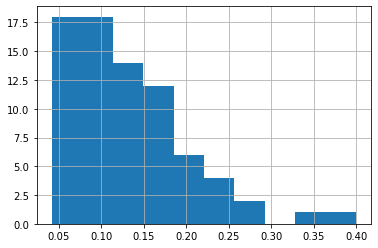

In [175]:
df_demo_c['unemployment'].hist()

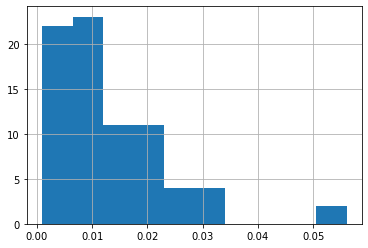

In [176]:
df_crime_c_neigh['ratio'].hist()

We account for the skewness by performing a logarithmic tranformation on our quantitative variables

In [139]:
for x in reg_c.columns[0:10]:
    log = np.log(reg_c[x])
    reg_c[x] = log

In [140]:
X = np.asarray(reg_c[reg_c.columns[0:10]])
print(X[0])
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

[-2.59026717 -1.48280526 10.88455428 -1.70374859 -3.14128457 -1.43543325
 -1.42563655 -0.80174968 -3.51117996 10.08326421]


array([[-0.87458683,  0.45861798,  0.84816942,  0.1244208 ,  0.43949095,
         0.23171032,  0.39357943,  0.81769196,  0.64251377,  0.15217364],
       [-0.77311146, -0.22295116,  1.31198899,  0.31188526,  1.00974172,
        -0.16714454,  0.25951003,  0.74893954,  0.95115753,  0.07596963],
       [-0.82319014,  0.45861798,  0.88761972, -0.48391918,  0.75860656,
         0.04456866,  0.07051174,  0.93640361,  0.66617962,  0.95264681],
       [-1.06593881, -0.99769791,  0.71314552, -0.30540628,  0.74868549,
        -0.57963421,  0.15646041,  1.04673947,  0.87087247,  1.04700527],
       [-1.87220966, -1.48453975,  0.35792814, -1.83730793,  0.45224051,
        -0.42383585, -0.28769174,  1.1788562 ,  0.83096107,  1.88361307]])

In [141]:
reg_c[reg_c.columns[0:10]] = X
reg_c.head()

,unemployment,poverty_rate,population,without_hsd,asian_pop,black_pop,hispanic_pop,white_pop,other_pop,pci,cluster_1,cluster_2,cluster_3,cluster_4,crime_ratio
0,-0.874587,0.458618,0.848169,0.124421,0.439491,0.231710,0.393579,0.817692,0.642514,0.152174,0,0,0,1,0.019490
1,-0.773111,-0.222951,1.311989,0.311885,1.009742,-0.167145,0.259510,0.748940,0.951158,0.075970,0,0,0,1,0.013914
2,-0.823190,0.458618,0.887620,-0.483919,0.758607,0.044569,0.070512,0.936404,0.666180,0.952647,0,0,1,0,0.012024
3,-1.065939,-0.997698,0.713146,-0.305406,0.748685,-0.579634,0.156460,1.046739,0.870872,1.047005,1,0,0,0,0.010715
4,-1.872210,-1.484540,0.357928,-1.837308,0.452241,-0.423836,-0.287692,1.178856,0.830961,1.883613,0,0,0,0,0.011490


In [142]:
reg_c.drop(index=[76], inplace=True)

In [143]:
x = np.asarray(reg_c[reg_c.columns[0:14]])
y = np.log(reg_c['crime_ratio'])

Finally we perform the regression

In [144]:
lr = LinearRegression()
lr

LinearRegression()

In [145]:
lr.fit(x, y)

LinearRegression()

In [146]:
yhat = lr.predict(x)

In [147]:
from sklearn.metrics import r2_score
r_squared = r2_score(y, yhat)
print('R-sqaured: {}'.format(r_squared))

R-sqaured: 0.687870854408598


Adjusted R-squared is reported due to the large number of variables inflating our R-squared score

In [148]:
adj_r_squared = 1 - ((1-r_squared)*((len(yhat)-1)/(len(yhat)-reg_c.shape[1])))

In [149]:
print(adj_r_squared)

0.6162346570597517


In [150]:
lr.intercept_

-4.380445015756911

In [151]:
lr.coef_

array([-0.01610357,  0.52212813,  0.43355654, -0.18954466,  0.02761477,
       -0.06482262,  0.06066266, -0.33335104, -0.06009252,  0.26418122,
        0.0720072 , -0.72989787, -0.45384583, -0.34574819])

The coefficient of every variable is described below

In [152]:
coefficients_c = pd.concat([pd.DataFrame(reg_c.columns[0:14]),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)
coefficients_c

,0,0
0,unemployment,-0.016104
1,poverty_rate,0.522128
2,population,0.433557
3,without_hsd,-0.189545
4,asian_pop,0.027615
5,black_pop,-0.064823
6,hispanic_pop,0.060663
7,white_pop,-0.333351
8,other_pop,-0.060093
9,pci,0.264181


Some observations:
* Oddly, a unit increase in unemployment, decreases the property crime ratio of a neighborhood by 0.01%. 
* Poverty and population increases the crime ratio by 0.52%. 
* Increases in both Black, Other, or White population decrease the crime rate
* Asian and Hispanic population increase the crime rate. 
* A unit increase in PCI increases the property crime ratio by 0.26%. 
* All neighborhoods belonging to Venue Cluster 3 are the mostly likely to experience lower crime ratio in comparision to our benchmark Cluster 1. 
* Cluster 2 is the most likely to experience a higher crime ratio than Cluster 1.

#### **New York City**

Similarly we prepare the regression dataframe for NYC from `df_demo_n`,`df_crime_n_neigh`, and the cluster labels

In [153]:
reg_n = df_ny
reg_n = reg_n.join(df_demo_n.set_index('Neighborhood'), on='Neighborhood')
reg_n = reg_n.join(n_merged_venue[['Neighborhood','Clusters']].set_index('Neighborhood'), on='Neighborhood')
reg_n = reg_n.join(df_crime_n_neigh[['Neighborhood','ratio']].set_index('Neighborhood'), on='Neighborhood')
reg_n.rename(columns={'Clusters':'cluster','ratio':'crime_ratio','poverty rate':'poverty_rate','pop aged 25 without hsd':'without_hsd'}, inplace=True)
reg_n.reset_index(inplace=True)
reg_n.drop(columns=['index'], inplace=True)
reg_n.head()

,Neighborhood,Latitude,Longitude,unemployment,poverty_rate,population,without_hsd,asian_pop,black_pop,hispanic_pop,white_pop,other_pop,median income,cluster,crime_ratio
0,North Shore,40.625868,-74.121420,0.052985,0.200258,174560,0.159116,0.091365,0.212375,0.301798,0.367099,0.027363,65995.32978,3,0.021143
1,East Harlem,40.797080,-73.937853,0.092744,0.337528,125108,0.262010,0.074297,0.292495,0.476014,0.137318,0.019876,34626.18585,3,0.031312
2,Mid-Island,40.591955,-74.139206,0.049128,0.108996,137478,0.114426,0.136783,0.042821,0.138292,0.661047,0.021056,83661.65114,3,0.012298
3,Washington Heights / Inwood,40.839632,-73.942751,0.092942,0.210649,224898,0.280442,0.029888,0.080457,0.683003,0.189328,0.017324,52977.54067,3,0.017122
4,Astoria,40.771347,-73.910056,0.059342,0.149257,171100,0.140745,0.154099,0.067739,0.267112,0.480503,0.030547,64569.48051,1,0.008798


Convert the clusters into dummy variables

In [155]:
reg_n_clusterdummy = pd.get_dummies(reg_n['cluster'])
reg_n = reg_n.join(reg_n_clusterdummy)
reg_n.drop(columns=['cluster'], inplace=True)
reg_n.rename(columns={0:'cluster_0',1:'cluster_1',2:'cluster_2',3:'cluster_3',4:'cluster_4'}, inplace=True)
reg_n_crime_ratio = reg_n['crime_ratio']
reg_n.drop(columns=['crime_ratio'], inplace=True)
reg_n.insert(18, 'crime_ratio', reg_n_crime_ratio)

Drop `cluster_0` as the benchmark dummy variable

In [156]:
reg_n.drop(columns=['cluster_0','Neighborhood','Latitude','Longitude'], inplace=True)  #To avoid falling into the Dummy Variable Trap
reg_n.head()

,unemployment,poverty_rate,population,without_hsd,asian_pop,black_pop,hispanic_pop,white_pop,other_pop,median income,cluster_1,cluster_2,cluster_3,cluster_4,crime_ratio
0,0.052985,0.200258,174560,0.159116,0.091365,0.212375,0.301798,0.367099,0.027363,65995.32978,0,0,1,0,0.021143
1,0.092744,0.337528,125108,0.262010,0.074297,0.292495,0.476014,0.137318,0.019876,34626.18585,0,0,1,0,0.031312
2,0.049128,0.108996,137478,0.114426,0.136783,0.042821,0.138292,0.661047,0.021056,83661.65114,0,0,1,0,0.012298
3,0.092942,0.210649,224898,0.280442,0.029888,0.080457,0.683003,0.189328,0.017324,52977.54067,0,0,1,0,0.017122
4,0.059342,0.149257,171100,0.140745,0.154099,0.067739,0.267112,0.480503,0.030547,64569.48051,1,0,0,0,0.008798


In [157]:
reg_n.shape

(54, 15)

In [158]:
print(reg_n.columns[0:10])

Index(['unemployment', 'poverty_rate', 'population', 'without_hsd',
       'asian_pop', 'black_pop', 'hispanic_pop', 'white_pop', 'other_pop',
       'median income'],
      dtype='object')


Perform logarithmic transformation on both dependent and independent variable (not including cluster dummies)

In [159]:
for x in reg_n.columns[0:10]:
    log = np.log(reg_n[x])
    reg_n[x] = log

In [160]:
X = np.asarray(reg_n[reg_n.columns[0:10]])
print(X[0])
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

[-2.93774869 -1.60814675 12.0700238  -1.83812178 -2.39289565 -1.54939982
 -1.19799736 -1.0021248  -3.59855404 11.09733926]


array([[-0.70790132,  0.27483548,  0.71224771, -0.07511815,  0.05914282,
         0.47062919,  0.36228441,  0.53498305,  0.09715461,  0.30917051],
       [ 0.88804413,  1.38577161, -0.97272976,  0.76395692, -0.13506737,
         0.72606419,  1.03035253, -0.3333199 , -0.58924127, -1.32015721],
       [-0.92333034, -1.01966487, -0.49577115, -0.62980473,  0.43812836,
        -0.80723349, -0.78181631,  1.05437246, -0.4653721 ,  0.90837502],
       [ 0.89412308,  0.38248528,  1.99398984,  0.87832672, -0.99027726,
        -0.30394537,  1.55967545, -0.04970853, -0.88428259, -0.24587413],
       [-0.3848828 , -0.35068126,  0.61097266, -0.28151083,  0.55007362,
        -0.44125047,  0.18329125,  0.77269593,  0.33349386,  0.25399312]])

In [161]:
reg_n[reg_n.columns[0:10]] = X
reg_n.head()

,unemployment,poverty_rate,population,without_hsd,asian_pop,black_pop,hispanic_pop,white_pop,other_pop,median income,cluster_1,cluster_2,cluster_3,cluster_4,crime_ratio
0,-0.707901,0.274835,0.712248,-0.075118,0.059143,0.470629,0.362284,0.534983,0.097155,0.309171,0,0,1,0,0.021143
1,0.888044,1.385772,-0.972730,0.763957,-0.135067,0.726064,1.030353,-0.333320,-0.589241,-1.320157,0,0,1,0,0.031312
2,-0.923330,-1.019665,-0.495771,-0.629805,0.438128,-0.807233,-0.781816,1.054372,-0.465372,0.908375,0,0,1,0,0.012298
3,0.894123,0.382485,1.993990,0.878327,-0.990277,-0.303945,1.559675,-0.049709,-0.884283,-0.245874,0,0,1,0,0.017122
4,-0.384883,-0.350681,0.610973,-0.281511,0.550074,-0.441250,0.183291,0.772696,0.333494,0.253993,1,0,0,0,0.008798


In [162]:
x = np.asarray(reg_n[reg_n.columns[0:14]])
y = np.log(reg_n['crime_ratio'])

Perform the regression

In [163]:
lr = LinearRegression()
lr

LinearRegression()

In [164]:
lr.fit(x, y)

LinearRegression()

In [165]:
yhat = lr.predict(x)

In [166]:
from sklearn.metrics import r2_score
r_squared = r2_score(y, yhat)
print('R-sqaured: {}'.format(r_squared))

R-sqaured: 0.6996891067505908


In [167]:
adj_r_squared = 1 - ((1-r_squared)*((len(yhat)-1)/(len(yhat)-reg_c.shape[1])))

Similarly, Adjusted R-squared is reported 

In [168]:
print(adj_r_squared)

0.591885196353367


In [169]:
lr.intercept_

-4.174944020759436

In [170]:
lr.coef_

array([-0.01346802,  1.0764531 ,  0.12531209, -0.75828785,  0.36231777,
        0.08343648,  0.14635248, -0.40118291, -0.11736754,  0.50962798,
       -0.14288226,  0.28240282, -0.04021559,  0.42419466])

The coefficient of each variable is defined below

In [171]:
coefficients_n = pd.concat([pd.DataFrame(reg_n.columns[0:14]),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)
coefficients_n

,0,0
0,unemployment,-0.013468
1,poverty_rate,1.076453
2,population,0.125312
3,without_hsd,-0.758288
4,asian_pop,0.362318
5,black_pop,0.083436
6,hispanic_pop,0.146352
7,white_pop,-0.401183
8,other_pop,-0.117368
9,median income,0.509628


Some observations:
* Again, a unit increase in unemployment decreases the crime ratio by 0.01%
* Here, unit increase in poverty rate increases crime ratio by 1.07%.
* Population also has a positive correlation with crime ratio here (unit increase increases crime by 0.12%).
* Meanwhile, Population aged 25 without a High-School Diploma has a negative effect on crime ratio
* In NYC, increases in White or Other Population have a negative effect on crime ratio, while all other populations increase the crime ratio in the sub-boroughs of NYC.
* A unit increase in Median Income increases the crime ratio by 0.5%.
* In comparison to Cluster 1 sub-boroughs, Cluster 2 and 4 sub-boroughs should experience lower crime ratios with Cluster 2 being the best
* While, Cluster 3 and 5 sub-boroughs experience higher crime ratios with Cluster 5 being the worst.

# Results

From both regression analyses we have seen that Unemployment, Population Aged 25 without High-School Diploma, and Income have a negative correlation with crime ratio. While, these may be erroneous results, it might be explained by the fact that higher-income neighborhoods/sub-boroughs are more likely to be targeted in the case of property crime, this would also explain the negative correlation between Unemployment and Population Aged 25 without High-School Diploma as high-income neighborhoods would also have lower rates of unemployment and higher rates of population that have at least achieved a high-school level of education.

In terms of this analysis' recommendations for entrepreneurs trying to choose a neighborhood in one of these cities to start a new venue where it is safest in terms of property crime, we make the following recommendations:

#### **Chicago**

Firstly, we should choose a neighborhood belonging to Venue Cluster 3 (`cluster_2`)

In [183]:
recommend_c = c_merged_venue[['Neighborhood','Clusters']]
recommend_c = recommend_c.join(df_demo_c.set_index('Neighborhood'), on='Neighborhood')
recommend_c = recommend_c.join(df_crime_c_neigh[['Neighborhood','ratio']].set_index('Neighborhood'), on='Neighborhood')
recommend_c = recommend_c.loc[recommend_c['Clusters']==2]
recommend_c

,Neighborhood,Clusters,unemployment,poverty rate,population,pop aged 25 without hsd,asian_pop,black_pop,hispanic_pop,white_pop,other_pop,pci,ratio
59,Bridgeport,2,0.112,0.173,32543.0,0.222,0.334911,0.058538,0.301201,0.297483,0.007867,22694.0,0.006012


Since there is only one neighbrohood in Cluster 3, we recommend Bridgeport as the safest neighborhood to start a new venue in Chicago

#### **New York City**

Firstly, we should choose a neighborhood belonging to Venue Cluster 2 (`cluster_1`)

In [194]:
recommend_n = n_merged_venue[['Neighborhood','Clusters']]
recommend_n = recommend_n.join(df_demo_n.set_index('Neighborhood'), on='Neighborhood')
recommend_n = recommend_n.join(df_crime_n_neigh[['Neighborhood','ratio']].set_index('Neighborhood'), on='Neighborhood')
recommend_n = recommend_n.loc[recommend_n['Clusters']==1]
recommend_n

,Neighborhood,Clusters,unemployment,poverty rate,population,pop aged 25 without hsd,asian_pop,black_pop,hispanic_pop,white_pop,other_pop,median income,ratio
5,Astoria,1,0.059342,0.149257,171100,0.140745,0.154099,0.067739,0.267112,0.480503,0.030547,64569.48051,0.008798
14,Hillcrest / Fresh Meadows,1,0.080896,0.128895,163193,0.136681,0.336426,0.118590,0.198557,0.303631,0.042795,66776.88834,0.010879
27,Mott Haven / Hunts Point,1,0.120996,0.408318,163773,0.389136,0.006969,0.289725,0.670032,0.022448,0.010825,25069.69555,0.025258
44,Brownsville / Ocean Hill,1,0.131329,0.348951,118907,0.234917,0.013644,0.717856,0.224885,0.027804,0.015811,28351.88456,0.023035
53,Bensonhurst,1,0.067998,0.184279,191525,0.256549,0.403927,0.010737,0.158654,0.404201,0.022481,53834.77753,0.007568


Next, we choose the sub-borough with the lowest crime rate, the biggest contributor to crime ratio. Here it is Bensonhurst

In [195]:
recommend_n = pd.DataFrame(recommend_n.loc[53])
recommend_n.T

,Neighborhood,Clusters,unemployment,poverty rate,population,pop aged 25 without hsd,asian_pop,black_pop,hispanic_pop,white_pop,other_pop,median income,ratio
53,Bensonhurst,1,0.067998,0.184279,191525,0.256549,0.403927,0.0107367,0.158654,0.404201,0.0224811,53834.8,0.00756787


And so we recommend Bensonhurst as the safest sub-borough to open a new venue in NYC.

# Discussion

In this analysis, our regression could only explain 59-61% of the variation in crime ratio as given by the Adjusted R-squared, making this model not very accurate. A possible extension of this analysis could be improving its accuracy by including more cities and years to extend the dataset and allow more observations to increase the accuracy.

The model could be further improved by including other variables such as average wage rates, venue prices in the clustering, level of police enforcement and others

Also no hypothesis testing was performed in the preliminary model to test the significance of the variables if any, other than the basic R-squared score

It should also be noted that the venue clustering will have different results everytime the notebook is run and thus change the results of the regression every time which may or may not be the same depending on Foursquare's venue popularity, day of the week, and time of the day. The study could be extended by running the clustering multiple times over the course of a period of time to get a more holistic view of the true dataset.